# Introduction
In this project, I create a ridge regression model to predict house values and gain insight into the effect of each feature. This notebook is part 2 of a three-notebook project on the [Melbourne Housing Market](https://www.kaggle.com/anthonypino/melbourne-housing-market) dataset created by Tony Pino, and in this notebook I perform more in-depth exploratory data analysis and data cleaning on the dataset. [Part 1](https://github.com/michellekli/melbourne-housing/blob/master/melbourne-housing-part1.ipynb) covers the initial exploratory data analysis. [Part 3](https://github.com/michellekli/melbourne-housing/blob/master/melbourne-housing-part3.ipynb) covers feature selection, model evaluation, and finally model interpretation.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hvplot.pandas
import geoviews as gv

%matplotlib inline
sns.set_style('white')
sns.set(font_scale=1.2)

In [2]:
# load data from end of last notebook
df = pd.read_pickle('data/melbourne-housing-part1.pickle')
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car_Clean,Bedroom2_Incorrect,Bathroom_Incorrect,Car_Incorrect,Landsize_Incorrect,Landsize_Clean,BuildingArea_Incorrect,BuildingArea_Clean,YearBuilt_Incorrect,YearBuilt_Clean
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067,...,1.0,0,0,0,0,126.0,0,NaN,0,NaN
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067,...,1.0,0,0,0,0,202.0,0,NaN,0,NaN
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067,...,0.0,0,0,0,0,156.0,0,79.0,0,1900.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067,...,1.0,0,0,0,1,NaN,0,NaN,0,NaN
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067,...,0.0,0,0,0,0,134.0,0,150.0,0,1900.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34856 entries, 0 to 34856
Data columns (total 41 columns):
Suburb                    34856 non-null object
Address                   34856 non-null object
Rooms                     34856 non-null int64
Type                      34856 non-null object
Price                     27247 non-null float64
Method                    34856 non-null object
SellerG                   34856 non-null object
Date                      34856 non-null object
Distance                  34855 non-null float64
Postcode                  34856 non-null object
Bedroom2                  26640 non-null float64
Bathroom                  26631 non-null float64
Car                       26128 non-null float64
Landsize                  23046 non-null float64
BuildingArea              13741 non-null float64
YearBuilt                 15550 non-null float64
CouncilArea               34853 non-null object
Regionname                34853 non-null object
Propertycount       

## Exploring numerical features

In [4]:
# create dataset with only numerical features
def get_numerical(df):
    numerical_columns = list(df.select_dtypes(include=[np.number]).columns.values)
    # find the columns for which we've cleaned values
    unclean_columns = [column.replace('_Clean', '') for column in numerical_columns if '_Clean' in column]
    # remove the original, uncleaned columns
    for unclean in unclean_columns:
        if unclean in numerical_columns:
            numerical_columns.remove(unclean)
    # find the columns for indicating incorrect values and remove them
    indicator_columns = [column for column in numerical_columns if '_Incorrect' in column]
    for indicator in indicator_columns:
        numerical_columns.remove(indicator)    

    return df[numerical_columns]
    
numerical_df = get_numerical(df)
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34856 entries, 0 to 34856
Data columns (total 16 columns):
Rooms                     34856 non-null int64
Price                     27247 non-null float64
Distance                  34855 non-null float64
Propertycount             34853 non-null float64
Latitude                  26880 non-null float64
Longitude                 26880 non-null float64
Year_Clean                34856 non-null int64
Months_From_2016_Clean    34856 non-null int64
Suburbcount               34856 non-null int64
Suburbcount_Normed        34856 non-null float64
Bedroom2_Clean            26640 non-null float64
Bathroom_Clean            26631 non-null float64
Car_Clean                 26128 non-null float64
Landsize_Clean            20609 non-null float64
BuildingArea_Clean        13664 non-null float64
YearBuilt_Clean           15548 non-null float64
dtypes: float64(12), int64(4)
memory usage: 4.5 MB


In [5]:
numerical_df.describe()

,Rooms,Price,Distance,Propertycount,Latitude,Longitude,Year_Clean,Months_From_2016_Clean,Suburbcount,Suburbcount_Normed,Bedroom2_Clean,Bathroom_Clean,Car_Clean,Landsize_Clean,BuildingArea_Clean,YearBuilt_Clean
count,34856.000000,2.724700e+04,34855.000000,34853.000000,26880.000000,26880.000000,34856.000000,34856.000000,34856.000000,34856.000000,26640.000000,26631.000000,26128.000000,20609.000000,13664.000000,15548.000000
mean,3.031013,1.050173e+06,11.184808,7572.962901,-37.810634,145.001845,2016.839941,17.221282,245.100471,0.033366,3.084910,1.624873,1.728988,663.800815,161.154672,1965.328081
std,0.969947,6.414671e+05,6.788952,4428.131940,0.090281,0.120167,0.636300,6.679224,174.502495,0.014636,0.980188,0.723992,1.010640,3587.782857,402.229545,36.800049
min,1.000000,8.500000e+04,0.000000,83.000000,-38.190430,144.423790,2016.000000,1.000000,1.000000,0.000084,0.000000,0.000000,0.000000,1.000000,1.000000,1800.000000
25%,2.000000,6.350000e+05,6.400000,4385.000000,-37.862950,144.933500,2016.000000,11.000000,111.000000,0.019191,2.000000,1.000000,1.000000,306.000000,102.000000,1940.000000
50%,3.000000,8.700000e+05,10.300000,6763.000000,-37.807600,145.007800,2017.000000,19.000000,201.000000,0.036926,3.000000,2.000000,2.000000,557.000000,136.000000,1970.000000
75%,4.000000,1.295000e+06,14.000000,10412.000000,-37.754092,145.071900,2017.000000,22.000000,374.000000,0.045096,4.000000,2.000000,2.000000,692.000000,188.000000,2000.000000
max,16.000000,1.120000e+07,48.100000,21650.000000,-37.390200,145.526350,2018.000000,27.000000,844.000000,0.078231,30.000000,12.000000,26.000000,433014.000000,44515.000000,2019.000000


### Examine features with strange values
* These features have values of 0: 'Distance', 'Bedroom2_Clean', 'Bathroom_Clean', 'Car_Clean'.
* These features have a very low min value: Propertycount', 'Landsize_Clean', 'BuildingArea_Clean'.
* These features have a very high max value: 'Rooms', 'Price', 'Distance', 'Bedroom2_Clean', 'Bathroom_Clean', 'Car_Clean', 'Landsize_Clean', 'BuildingArea_Clean'.

#### Examining features with values of 0
These features have values of 0: 'Distance', 'Bedroom2_Clean', 'Bathroom_Clean', 'Car_Clean'.

##### Distance
This feature is "Distance from CBD in Kilometres" and CBD stands for Central Business District. If the property was located in the CBD, distance could be 0.

In [6]:
df['Distance'].describe()

count    34855.000000
mean        11.184808
std          6.788952
min          0.000000
25%          6.400000
50%         10.300000
75%         14.000000
max         48.100000
Name: Distance, dtype: float64

In [7]:
df.loc[df['Distance'] == 0].shape

(77, 41)

In [8]:
# can use Postcode to see if these properties are in the CBD
df.loc[df['Distance'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 15114 to 34472
Data columns (total 41 columns):
Suburb                    77 non-null object
Address                   77 non-null object
Rooms                     77 non-null int64
Type                      77 non-null object
Price                     58 non-null float64
Method                    77 non-null object
SellerG                   77 non-null object
Date                      77 non-null object
Distance                  77 non-null float64
Postcode                  77 non-null object
Bedroom2                  10 non-null float64
Bathroom                  10 non-null float64
Car                       8 non-null float64
Landsize                  8 non-null float64
BuildingArea              6 non-null float64
YearBuilt                 9 non-null float64
CouncilArea               77 non-null object
Regionname                77 non-null object
Propertycount             77 non-null float64
Latitude                  12 no

In [9]:
# all these properties are in Postcode 3000
df.loc[df['Distance'] == 0, 'Postcode'].value_counts()

3000    77
Name: Postcode, dtype: int64

According to the [Wikipedia page](https://en.wikipedia.org/wiki/Melbourne_City_Centre) for Melbourne's CBD, 3000 is one of its postcodes so these values of 0 distance are reasonable.

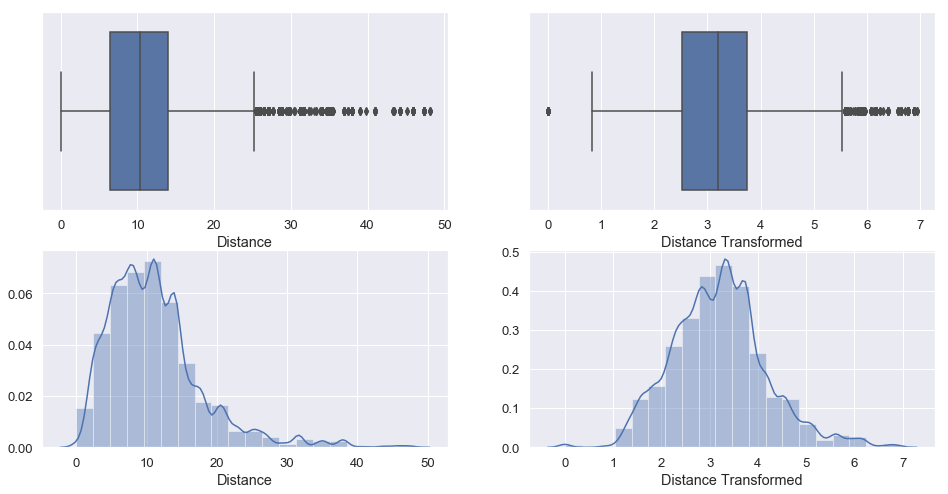

In [10]:
# sqrt-transformed values seems normally distributed
fig, axes = plt.subplots(2, 2)
column = 'Distance'
column_lessthan = 50
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0], bins=20)
sns.boxplot(np.sqrt(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.sqrt(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1], bins=20)
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

##### Bedroom2
This feature is "Scraped # of Bedrooms (from different source)". From the previous notebook, we know that Rooms and Bedroom2 represent the same thing, the number of bedrooms in the property.

In [11]:
df.loc[df['Bedroom2_Clean'] == 0].shape

(14, 41)

In [12]:
# can see if Rooms is also 0
df.loc[df['Bedroom2_Clean'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 218 to 18304
Data columns (total 41 columns):
Suburb                    14 non-null object
Address                   14 non-null object
Rooms                     14 non-null int64
Type                      14 non-null object
Price                     14 non-null float64
Method                    14 non-null object
SellerG                   14 non-null object
Date                      14 non-null object
Distance                  14 non-null float64
Postcode                  14 non-null object
Bedroom2                  14 non-null float64
Bathroom                  14 non-null float64
Car                       14 non-null float64
Landsize                  14 non-null float64
BuildingArea              5 non-null float64
YearBuilt                 5 non-null float64
CouncilArea               14 non-null object
Regionname                14 non-null object
Propertycount             14 non-null float64
Latitude                  14 no

In [13]:
# none of these properties have Rooms = 0, so these Bedroom2
# values are probably incorrect
df.loc[df['Bedroom2_Clean'] == 0, ['Rooms']]

,Rooms
218,2
1390,3
1424,3
1549,3
5547,4
10107,3
11234,3
12013,3
12217,3
13558,4


In [14]:
numerical_df.columns

Index(['Rooms', 'Price', 'Distance', 'Propertycount', 'Latitude', 'Longitude',
       'Year_Clean', 'Months_From_2016_Clean', 'Suburbcount',
       'Suburbcount_Normed', 'Bedroom2_Clean', 'Bathroom_Clean', 'Car_Clean',
       'Landsize_Clean', 'BuildingArea_Clean', 'YearBuilt_Clean'],
      dtype='object')

In [15]:
# create column to replace incorrect Bedroom2 values with NaN
df.loc[df['Bedroom2_Clean'] == 0, 'Bedroom2_Incorrect'] = 1
df.loc[df['Bedroom2_Clean'] == 0, 'Bedroom2_Clean'] = np.NaN

In [16]:
# no more 0 values
df['Bedroom2_Clean'].describe()

count    26626.000000
mean         3.086532
std          0.977889
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         30.000000
Name: Bedroom2_Clean, dtype: float64

##### Bathroom
This feature is "Number of Bathrooms".

In [17]:
df.loc[df['Bathroom_Clean'] == 0].shape

(43, 41)

In [18]:
# can see if Rooms, Bedroom2_Clean, Car, BuildingArea_Clean are also 0
df.loc[df['Bathroom_Clean'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43 entries, 228 to 18304
Data columns (total 41 columns):
Suburb                    43 non-null object
Address                   43 non-null object
Rooms                     43 non-null int64
Type                      43 non-null object
Price                     32 non-null float64
Method                    43 non-null object
SellerG                   43 non-null object
Date                      43 non-null object
Distance                  43 non-null float64
Postcode                  43 non-null object
Bedroom2                  43 non-null float64
Bathroom                  43 non-null float64
Car                       43 non-null float64
Landsize                  43 non-null float64
BuildingArea              0 non-null float64
YearBuilt                 2 non-null float64
CouncilArea               43 non-null object
Regionname                43 non-null object
Propertycount             43 non-null float64
Latitude                  43 no

In [19]:
# all these properties have Rooms, but no Bathrooms
# there is one property with a Car spot
# it's very strange that these properties do not have a Bathroom
df.loc[df['Bathroom_Clean'] == 0, ['Rooms', 'Bedroom2_Clean', 'Car_Clean', 'BuildingArea_Clean']]

,Rooms,Bedroom2_Clean,Car_Clean,BuildingArea_Clean
228,3,3.0,0.0,NaN
481,2,2.0,0.0,NaN
845,2,2.0,0.0,NaN
1009,2,2.0,0.0,NaN
1549,3,NaN,0.0,NaN
1772,3,3.0,0.0,NaN
1784,3,3.0,1.0,NaN
2716,4,3.0,0.0,NaN
2853,3,3.0,0.0,NaN
4434,2,2.0,0.0,NaN


In [20]:
df.loc[df['Bathroom_Clean'] == 0,
       ['Address', 'Suburb', 'Price', 'SellerG', 'Date', 'Rooms', 'Bedroom2_Clean', 'Car_Clean']].sample(n=3, random_state=42)

,Address,Suburb,Price,SellerG,Date,Rooms,Bedroom2_Clean,Car_Clean
14870,5/33 Grange Rd,Caulfield East,350000.0,Gary,3/06/2017,2,2.0,0.0
10485,1/183 Kooyong Rd,Toorak,857000.0,Walsh,22/08/2016,2,2.0,0.0
10518,6/183 Kooyong Rd,Toorak,866000.0,Marshall,30/07/2016,2,2.0,0.0


I looked up these three properties ([14870](https://www.domain.com.au/property-profile/5-33-grange-road-caulfield-east-vic-3145), [10485](https://www.domain.com.au/property-profile/1-183-kooyong-road-toorak-vic-3142), [10518](https://www.domain.com.au/property-profile/6-183-kooyong-road-toorak-vic-3142)) and all of them had at least one bathroom, so the rest of the Bathroom=0 values are probably also incorrect.

In [21]:
# correct values for these properties
df.loc[14870, 'Bathroom_Clean'] = 1
df.loc[14870, 'Car_Clean'] = 1

df.loc[10485, 'Bathroom_Clean'] = 2
df.loc[10485, 'Car_Clean'] = 1

df.loc[10518, 'Bathroom_Clean'] = 1
df.loc[10518, 'Car_Clean'] = 1

# indicate they were incorrect
df.loc[[14870, 10485, 10518], 'Bathroom_Incorrect'] = 1
df.loc[[14870, 10485, 10518], 'Car_Incorrect'] = 1

In [22]:
df['Bathroom_Clean'].describe()

count    26631.000000
mean         1.625023
std          0.723810
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         12.000000
Name: Bathroom_Clean, dtype: float64

In [23]:
# 40 properties with 0 values
df.loc[df['Bathroom_Clean'] == 0, :].shape

(40, 41)

In [24]:
# replace incorrect Bathroom values with NaN
df.loc[df['Bathroom_Clean'] == 0, 'Bathroom_Incorrect'] = 1
df.loc[df['Bathroom_Clean'] == 0, 'Bathroom_Clean'] = np.NaN

In [25]:
# values have been set to NaN
df['Bathroom_Clean'].describe()

count    26591.000000
mean         1.627468
std          0.721603
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         12.000000
Name: Bathroom_Clean, dtype: float64

##### Car
This feature is "Number of carspots".

In [26]:
df.loc[df['Car_Clean'] == 0].shape

(1625, 41)

In [27]:
# can see if Rooms, Bedroom2, Bathroom, Landsize, BuildingArea are also 0
df.loc[df['Car_Clean'] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1625 entries, 2 to 34856
Data columns (total 41 columns):
Suburb                    1625 non-null object
Address                   1625 non-null object
Rooms                     1625 non-null int64
Type                      1625 non-null object
Price                     1246 non-null float64
Method                    1625 non-null object
SellerG                   1625 non-null object
Date                      1625 non-null object
Distance                  1625 non-null float64
Postcode                  1625 non-null object
Bedroom2                  1625 non-null float64
Bathroom                  1625 non-null float64
Car                       1625 non-null float64
Landsize                  1543 non-null float64
BuildingArea              823 non-null float64
YearBuilt                 941 non-null float64
CouncilArea               1625 non-null object
Regionname                1625 non-null object
Propertycount             1625 non-null f

In [28]:
# this random subset of properties have Rooms, Bedrooms, and Bathrooms, but no Car spots
# it's possible that these properties don't have a Car spot
df.loc[df['Car_Clean'] == 0, ['Rooms', 'Bedroom2_Clean', 'Bathroom_Clean', 'Landsize_Clean',
                        'Address', 'Suburb', 'Type']].sample(n=20, random_state=42)

,Rooms,Bedroom2_Clean,Bathroom_Clean,Landsize_Clean,Address,Suburb,Type
3239,2,2.0,1.0,100.0,2A Council St,Clifton Hill,h
8806,2,2.0,1.0,178.0,73 Brighton St,Richmond,h
13058,3,3.0,NaN,219.0,1/53 Norman St,Ivanhoe,t
18685,2,2.0,2.0,100.0,74 Aberdeen Rd,Prahran,h
10300,2,2.0,1.0,NaN,84 Raleigh St,Thornbury,h
17836,3,3.0,1.0,142.0,143 Charles St,Abbotsford,h
33740,3,3.0,2.0,105.0,4 Clarendon Pl,South Melbourne,h
12811,2,2.0,1.0,267.0,75 MacPherson St,Footscray,h
14042,2,2.0,1.0,NaN,6/5 Alfriston St,Elwood,u
5113,1,1.0,2.0,994.0,136 Thomas St,Hampton,h


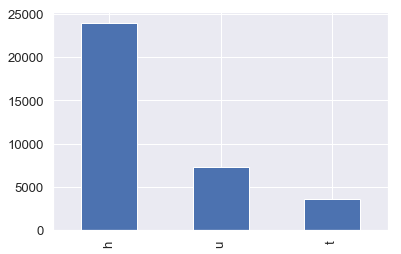

In [29]:
df['Type'].value_counts().plot.bar()
plt.show()

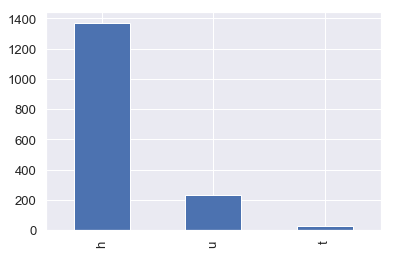

In [30]:
# properties
df.loc[df['Car_Clean'] == 0, 'Type'].value_counts().plot.bar()
plt.show()

In [31]:
df.loc[df['Car_Clean'] == 0, ['Address', 'Suburb', 'Postcode', 'Price', 'SellerG', 'Date',
                              'Rooms', 'Bedroom2', 'Bathroom']].sample(n=16, random_state=42)

,Address,Suburb,Postcode,Price,SellerG,Date,Rooms,Bedroom2,Bathroom
3239,2A Council St,Clifton Hill,3068,880000.0,Nelson,18/03/2017,2,2.0,1.0
8806,73 Brighton St,Richmond,3121,1340000.0,Kay,12/11/2016,2,2.0,1.0
13058,1/53 Norman St,Ivanhoe,3079,1060000.0,Purplebricks,29/04/2017,3,3.0,0.0
18685,74 Aberdeen Rd,Prahran,3181,NaN,hockingstuart,15/07/2017,2,2.0,2.0
10300,84 Raleigh St,Thornbury,3071,760000.0,Nelson,16/04/2016,2,2.0,1.0
17836,143 Charles St,Abbotsford,3067,1635000.0,Nelson,12/08/2017,3,3.0,1.0
33740,4 Clarendon Pl,South Melbourne,3205,1640000.0,Marshall,17/03/2018,3,3.0,2.0
12811,75 MacPherson St,Footscray,3011,885000.0,Jas,8/04/2017,2,2.0,1.0
14042,6/5 Alfriston St,Elwood,3184,642000.0,hockingstuart,20/05/2017,2,2.0,1.0
5113,136 Thomas St,Hampton,3188,2450000.0,Buxton,27/11/2016,1,1.0,2.0


I looked up these properties online and listed the number of car spots stated (a dash '-' for car spot on domain.com.au means there are 0 car spots):

* [Property 3239](https://www.domain.com.au/property-profile/2a-council-street-clifton-hill-vic-3068) 0
* [Property 8806](https://www.domain.com.au/property-profile/73-brighton-street-richmond-vic-3121) 0
* [Property 13058](https://www.domain.com.au/property-profile/1-53-norman-street-ivanhoe-vic-3079) 2
* [Property 18685](https://www.domain.com.au/property-profile/74-aberdeen-road-prahran-vic-3181) 0
* [Property 10300](https://www.domain.com.au/property-profile/84-raleigh-street-thornbury-vic-3071) 0
* [Property 17836](https://www.domain.com.au/property-profile/143-charles-street-abbotsford-vic-3067) 0
* [Property 33740](https://www.domain.com.au/property-profile/4-clarendon-place-south-melbourne-vic-3205) 1
* [Property 12811](https://www.domain.com.au/property-profile/75-macpherson-street-footscray-vic-3011) 0
* [Property 14042](https://www.domain.com.au/property-profile/6-5-alfriston-street-elwood-vic-3184) 0
* [Property 5113](https://www.domain.com.au/property-profile/136-thomas-street-hampton-vic-3188) 2
* [Property 11165](https://www.domain.com.au/property-profile/106-canning-street-carlton-vic-3053) 0
* [Property 24817](https://www.domain.com.au/property-profile/26a-sussex-street-yarraville-vic-3013) 0
* [Property 12677](https://www.domain.com.au/property-profile/71-palmer-street-collingwood-vic-3066) 0
* [Property 179](https://www.domain.com.au/property-profile/32-page-street-albert-park-vic-3206) 0
* [Property 9213](https://www.domain.com.au/property-profile/7-32-marne-street-south-yarra-vic-3141) 0
* [Property 9120](https://www.domain.com.au/property-profile/32-bridport-street-south-melbourne-vic-3205) 1

The majority (75%) of this random sample I examined are correct in that there are 0 car spots listed on the website, so I will assume the rest of the Car=0 values in the dataset are correct.

In [32]:
# correcting the incorrect car spots that were found
df.loc[13058, 'Car_Clean'] = 2
df.loc[33740, 'Car_Clean'] = 1
df.loc[5113, 'Car_Clean'] = 2
df.loc[9120, 'Car_Clean'] = 1

df.loc[[13058, 33740, 5113, 9120], 'Car_Incorrect'] = 1

#### Check results of cleaning

In [33]:
# no more strange 0 values
df[[column for column in df.columns if '_Clean' in column]].describe()

,Year_Clean,Months_From_2016_Clean,Bedroom2_Clean,Bathroom_Clean,Car_Clean,Landsize_Clean,BuildingArea_Clean,YearBuilt_Clean
count,34856.000000,34856.000000,26626.000000,26591.000000,26128.000000,20609.000000,13664.000000,15548.000000
mean,2016.839941,17.221282,3.086532,1.627468,1.729333,663.800815,161.154672,1965.328081
std,0.636300,6.679224,0.977889,0.721603,1.010297,3587.782857,402.229545,36.800049
min,2016.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1800.000000
25%,2016.000000,11.000000,2.000000,1.000000,1.000000,306.000000,102.000000,1940.000000
50%,2017.000000,19.000000,3.000000,2.000000,2.000000,557.000000,136.000000,1970.000000
75%,2017.000000,22.000000,4.000000,2.000000,2.000000,692.000000,188.000000,2000.000000
max,2018.000000,27.000000,30.000000,12.000000,26.000000,433014.000000,44515.000000,2019.000000


#### Examining features with very low min values
These features have a very low min value: 'Propertycount', 'Landsize_Clean', 'BuildingArea_Clean'.

##### Propertycount
This feature is "Number of properties that exist in the suburb".

In [34]:
df['Propertycount'].describe()

count    34853.000000
mean      7572.962901
std       4428.131940
min         83.000000
25%       4385.000000
50%       6763.000000
75%      10412.000000
max      21650.000000
Name: Propertycount, dtype: float64

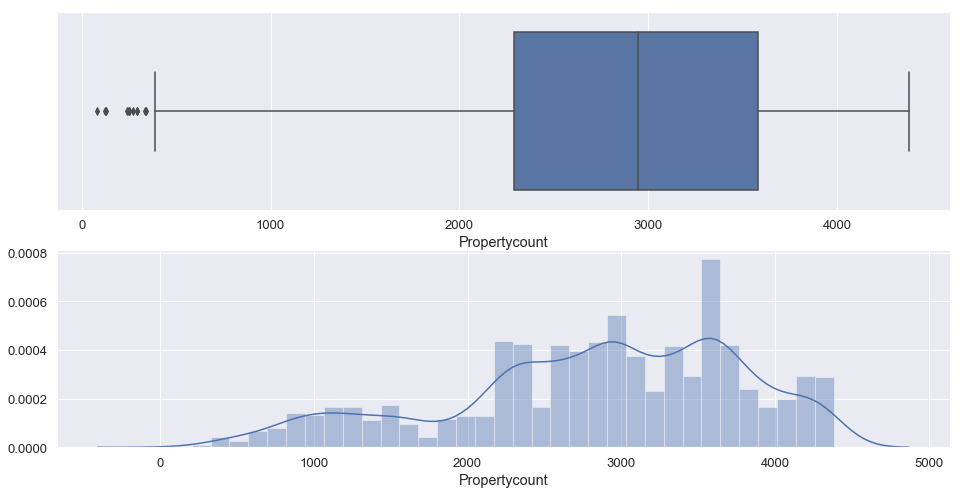

In [35]:
# a few very low values < 500
fig, axes = plt.subplots(2, 1)
column = 'Propertycount'
column_lessthan = 4385
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1])
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [36]:
# 13 suburbs have property count < 500
df.loc[df['Propertycount'] < 500, ['Suburb']].nunique()

Suburb    13
dtype: int64

In [37]:
df.loc[df['Propertycount'] < 500, ['Propertycount', 'Suburb']].drop_duplicates(subset='Suburb').sort_values(by='Propertycount')

,Propertycount,Suburb
24800,83.0,Wildwood
33450,121.0,Kalkallo
20576,129.0,Guys Hill
27882,242.0,Hopetoun Park
17930,249.0,Bullengarook
27593,271.0,Bulla
25964,290.0,Gisborne South
24188,335.0,Avonsleigh
34485,342.0,Menzies Creek
12024,389.0,Strathmore Heights


I looked up the three suburbs with the lowest property counts and recorded their population according to the 2016 Census. 

* [Wildwood](https://en.wikipedia.org/wiki/Wildwood,_Victoria) pop: 216
* [Kalkallo](https://en.wikipedia.org/wiki/Kalkallo,_Victoria) pop: 105
* [Guys Hill](https://en.wikipedia.org/wiki/Guys_Hill,_Victoria) pop: 382

Since the population of these suburbs is so low, it's reasonable for their property counts to also be very low.

##### Landsize
This feature is "Land Size in Metres".

In [38]:
df['Landsize'].describe()

count     23046.000000
mean        593.607177
std        3398.915462
min           0.000000
25%         224.000000
50%         521.000000
75%         670.000000
max      433014.000000
Name: Landsize, dtype: float64

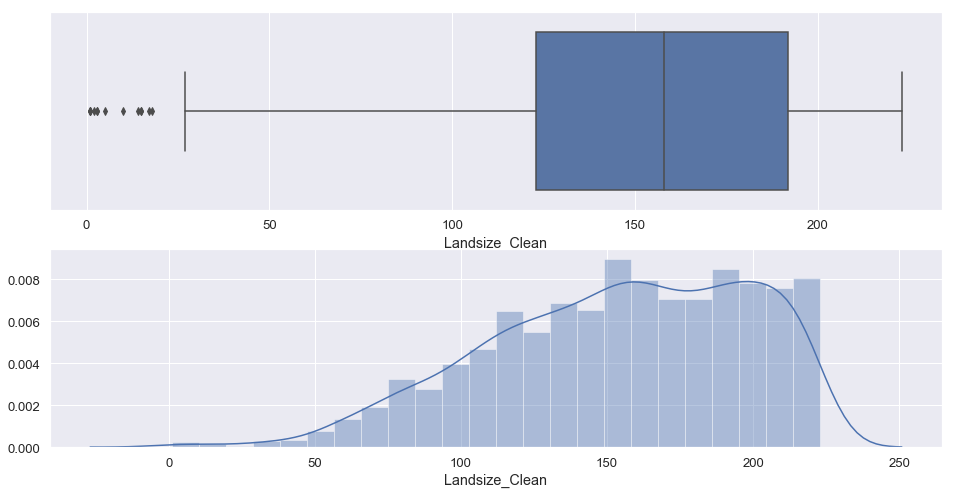

In [39]:
# some very low values < 25
fig, axes = plt.subplots(2, 1)
column = 'Landsize_Clean'
column_lessthan = 224
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1])
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [40]:
# 13 properties have landsize < 25
df.loc[df['Landsize_Clean'] < 25, :].shape

(13, 41)

In [41]:
df.loc[df['Landsize_Clean'] < 25, ['Landsize_Clean', 'BuildingArea_Clean', 'Address', 'Suburb', 'Postcode',
                                   'Price', 'SellerG', 'Date_Clean']].sort_values(by='Landsize_Clean')

,Landsize_Clean,BuildingArea_Clean,Address,Suburb,Postcode,Price,SellerG,Date_Clean
5489,1.0,NaN,190 Southern Rd,Heidelberg West,3081,710000.0,Haughton,2016-11-27
17436,1.0,62.0,4/463 South Rd,Bentleigh,3204,380000.0,Hodges,2017-07-08
17560,1.0,102.0,53 Botanic Dr,Glen Waverley,3150,NaN,JY,2017-07-08
12567,2.0,NaN,2/13 Emily St,Carnegie,3163,603000.0,hockingstuart,2017-05-20
14180,3.0,131.0,32/637 Orrong Rd,Toorak,3142,1320000.0,Gary,2017-04-29
16605,3.0,NaN,10/567 Toorak Rd,Toorak,3142,NaN,hockingstuart,2017-06-24
18207,5.0,NaN,40 Gadd St,Northcote,3070,1955000.0,McGrath,2017-08-12
18727,10.0,NaN,4/4 Powell St,South Yarra,3141,401500.0,hockingstuart,2017-07-15
9867,14.0,NaN,2/86 Phoenix St,Sunshine North,3020,315000.0,Douglas,2016-10-08
13663,15.0,15.0,6/38 Chambers St,South Yarra,3141,1320000.0,RT,2017-05-06


I looked up the three properties with the lowest land areas and recorded their land areas and building areas (if provided). 

* [Property 5489](https://www.onthehouse.com.au/property/vic/heidelberg-west-3081/190-southern-rd-heidelberg-west-vic-3081-10017889) land: 296
* [Property 17436](https://www.onthehouse.com.au/property/vic/bentleigh-3204/4-463-south-rd-bentleigh-vic-3204-12108922) land: 290, building: 62
* [Property 17560](https://www.onthehouse.com.au/property/vic/glen-waverley-3150/53-botanic-dr-glen-waverley-vic-3150-7202660) land: 739, building 102

The land areas are much higher than the values in the dataset, so the other low landsize values are likely to be incorrect as well. Interestingly, the building area values were correct.

Some [online research](https://buildsearch.com.au/house-size) shows that the average building area in VIC for all new homes built in 2016/107 was 198.8 square meters. The [site](https://www.domain.com.au/news/australians-are-paying-more-for-less-land-heres-why-20180916-h15dk1-763835/) from which most of this dataset was scraped says the average landsize in Melbourne was 450 square meters in 2017. This [analysis](https://chartingtransport.com/2016/05/22/are-melbourne-suburbs-full-of-quarter-acre-blocks/) of land sizes from 2016 states that suburbs in the inner city have lower block sizes on average and describes the range of land sizes as follows: 
> Inner city Carlton has the lowest median of 100-120 square metres, followed by Cremorne, North Melbourne, South Melbourne at 120-140 square metres, and then Abbotsford, Fitzroy North, Port Melbourne, Richmond, West Melbourne at 140-160 square metres. Urbanised suburbs at the other end of the scale include Park Orchards at 3020, Selby at 1440, and Warrandyte at 1260.

In [42]:
smallest_landsizes = ['Carlton', 'Cremorne', 'North Melbourne', 'South Melbourne','Abbotsford', 'Fitzroy North',
                      'Port Melbourne', 'Richmond', 'West Melbourne']

In [43]:
df.loc[df['Suburb'].isin(smallest_landsizes), 'Suburb'].value_counts()

Richmond           552
Port Melbourne     371
South Melbourne    194
Fitzroy North      184
North Melbourne    159
Abbotsford         137
Carlton             98
West Melbourne      66
Cremorne            47
Name: Suburb, dtype: int64

In [44]:
# examining the smallest recorded land sizes for the suburbs with the lowest median land sizes
df.loc[df['Suburb'].isin(smallest_landsizes),
       ['Landsize_Clean', 'BuildingArea_Clean', 'Address', 'Suburb', 'Postcode',
        'Price', 'SellerG', 'Date_Clean']].sort_values(by='Landsize_Clean').head()

,Landsize_Clean,BuildingArea_Clean,Address,Suburb,Postcode,Price,SellerG,Date_Clean
17817,17.0,90.0,125/33 Jeffcott St,West Melbourne,3003,670000.0,MICM,2017-07-08
24272,29.0,NaN,2 Challis La,Carlton,3053,840000.0,Nelson,2017-10-14
15845,37.0,NaN,141 Howard St,North Melbourne,3051,780000.0,Nick,2017-06-17
10613,54.0,89.0,8/115 Stanley St,West Melbourne,3003,800000.0,Nelson,2016-08-06
34576,54.0,90.0,59 Stawell St,North Melbourne,3051,NaN,Jellis,2018-02-24


I looked up the three properties with the lowest land areas and recorded their land areas and building areas (if provided). 

* [Property 24272](https://www.propertyvalue.com.au/property/2-challis-lane-carlton-vic-3053/17976501) land: 29, building: 88
* [Property 15845](https://www.propertyvalue.com.au/property/141-howard-street-north-melbourne-vic-3051/16052494) land: 37
* [Property 34576](https://www.propertyvalue.com.au/property/59-stawell-street-north-melbourne-vic-3051/12311074) land: 54, building: 90

These values all match what is recorded in the data set, which means there do exist properties with land size 29 and building area 88.

In [45]:
df['Landsize_Clean'].describe()

count     20609.000000
mean        663.800815
std        3587.782857
min           1.000000
25%         306.000000
50%         557.000000
75%         692.000000
max      433014.000000
Name: Landsize_Clean, dtype: float64

In [46]:
# these 15 properties' land sizes are unlikely to be correct
df.loc[df['Landsize_Clean'] < 29, :].shape

(15, 41)

In [47]:
# replace incorrect land size values with NaN
df.loc[df['Landsize_Clean'] < 29, 'Landsize_Incorrect'] = 1
df.loc[df['Landsize_Clean'] < 29, 'Landsize_Clean'] = np.NaN

In [48]:
# values have been set to NaN
df['Landsize_Clean'].describe()

count     20594.000000
mean        664.276537
std        3589.045967
min          29.000000
25%         306.000000
50%         557.000000
75%         692.000000
max      433014.000000
Name: Landsize_Clean, dtype: float64

##### BuildingArea
This feature is "Building Size in Metres".

In [49]:
df['BuildingArea_Clean'].describe()

count    13664.000000
mean       161.154672
std        402.229545
min          1.000000
25%        102.000000
50%        136.000000
75%        188.000000
max      44515.000000
Name: BuildingArea_Clean, dtype: float64

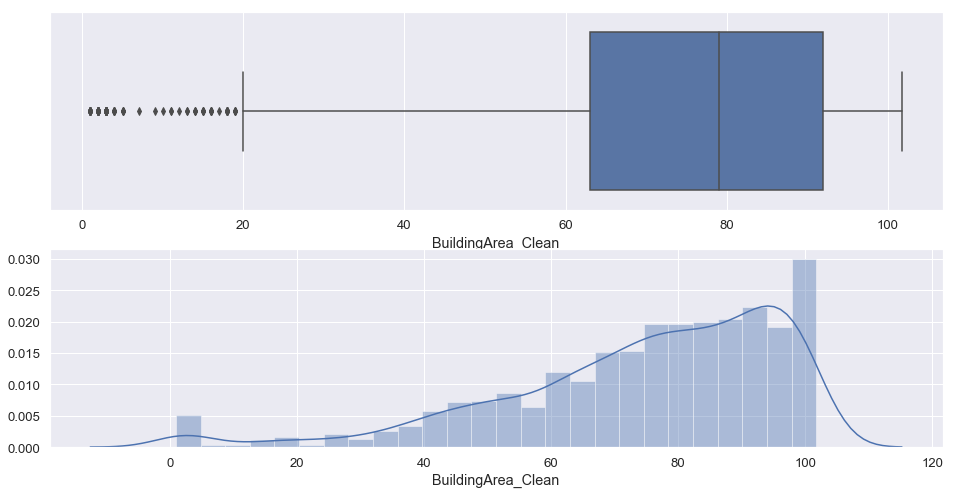

In [50]:
# some very low values < 20
fig, axes = plt.subplots(2, 1)
column = 'BuildingArea_Clean'
column_lessthan = 102
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1])
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [51]:
# 103 properties have landsize < 25
df.loc[df['BuildingArea_Clean'] < 20, :].shape

(103, 41)

In [52]:
# examining the smallest recorded building areas for the suburbs with the lowest median land sizes
# there is a jump from a value of 4 to 16
df.loc[df['Suburb'].isin(smallest_landsizes),
       ['Landsize_Clean', 'BuildingArea_Clean', 'Address', 'Suburb', 'Postcode',
        'Price', 'SellerG', 'Date_Clean']].sort_values(by='BuildingArea_Clean').head(20)

,Landsize_Clean,BuildingArea_Clean,Address,Suburb,Postcode,Price,SellerG,Date_Clean
7269,NaN,1.0,11/19 Wood St,North Melbourne,3051,587134.0,Woodards,2016-08-28
8787,NaN,1.0,5/285 Punt Rd,Richmond,3121,342000.0,Jellis,2016-09-10
14533,91.0,2.0,187 Errol St,North Melbourne,3051,962000.0,Alexkarbon,2017-07-01
7264,NaN,2.0,2/101 Leveson St,North Melbourne,3051,950000.0,hockingstuart,2016-05-28
13648,438.0,2.0,5 Park Pl,South Melbourne,3205,650000.0,hockingstuart,2017-04-08
8876,NaN,2.0,21A Kent St,Richmond,3121,842000.0,Jellis,2017-03-18
4311,157.0,3.0,44 McKean St,Fitzroy North,3068,NaN,Nelson,2016-09-24
9176,111.0,3.0,10 Coote St,South Melbourne,3205,1185000.0,Parkinson,2016-04-23
4328,NaN,4.0,42 Barkly St,Fitzroy North,3068,NaN,Nelson,2016-07-30
16483,NaN,16.0,706/65 Beach St,Port Melbourne,3207,NaN,RT,2017-06-24


I looked up the five properties with building areas between 15-31 and recorded their land areas and building areas (if provided). 

* [Property 16483](https://www.onthehouse.com.au/property/vic/port-melbourne-3207/706-65-beach-st-port-melbourne-vic-3207-6555466) land: 1610, building: 16
* [Property 55](https://www.propertyvalue.com.au/property/166-gipps-street-abbotsford-vic-3067/9146621) land: 147, building: 152
* [Property 23551](https://www.propertyvalue.com.au/property/69-yarra-street-abbotsford-vic-3067/14592937) land: 133, building 20
* [Property 41](https://www.onthehouse.com.au/property/vic/abbotsford-3067/138-56-nicholson-st-abbotsford-vic-3067-11125785) land: 4304, building: 27
* [Property 14296](https://www.propertyvalue.com.au/property/5/50-barkly-street-carlton-vic-3053/10274107) building: 32


Most of these building areas were correct, so the lower building area values < 16 are suspect.

In [53]:
df['BuildingArea_Clean'].describe()

count    13664.000000
mean       161.154672
std        402.229545
min          1.000000
25%        102.000000
50%        136.000000
75%        188.000000
max      44515.000000
Name: BuildingArea_Clean, dtype: float64

In [54]:
# these 85 properties' land sizes are unlikely to be correct
df.loc[df['BuildingArea_Clean'] < 16, :].shape

(85, 41)

In [55]:
# replace incorrect building area values with NaN
df.loc[df['BuildingArea_Clean'] < 16, 'BuildingArea_Incorrect'] = 1
df.loc[df['BuildingArea_Clean'] < 16, 'BuildingArea_Clean'] = np.NaN

In [56]:
# values have been set to NaN
df['BuildingArea_Clean'].describe()

count    13579.000000
mean       162.136788
std        403.294252
min         16.000000
25%        103.000000
50%        137.000000
75%        189.000000
max      44515.000000
Name: BuildingArea_Clean, dtype: float64

#### Check results of cleaning

In [57]:
# no more strangely low values
df[[column for column in df.columns if '_Clean' in column]].describe()

,Year_Clean,Months_From_2016_Clean,Bedroom2_Clean,Bathroom_Clean,Car_Clean,Landsize_Clean,BuildingArea_Clean,YearBuilt_Clean
count,34856.000000,34856.000000,26626.000000,26591.000000,26128.000000,20594.000000,13579.000000,15548.000000
mean,2016.839941,17.221282,3.086532,1.627468,1.729333,664.276537,162.136788,1965.328081
std,0.636300,6.679224,0.977889,0.721603,1.010297,3589.045967,403.294252,36.800049
min,2016.000000,1.000000,1.000000,1.000000,0.000000,29.000000,16.000000,1800.000000
25%,2016.000000,11.000000,2.000000,1.000000,1.000000,306.000000,103.000000,1940.000000
50%,2017.000000,19.000000,3.000000,2.000000,2.000000,557.000000,137.000000,1970.000000
75%,2017.000000,22.000000,4.000000,2.000000,2.000000,692.000000,189.000000,2000.000000
max,2018.000000,27.000000,30.000000,12.000000,26.000000,433014.000000,44515.000000,2019.000000


#### Examining features with very high max values
These features have a very high max value: 'Price', 'Distance', 'Rooms', 'Bedroom2_Clean', 'Bathroom_Clean', 'Car_Clean', 'Landsize_Clean', 'BuildingArea_Clean'.

##### Price
This feature is "Price in Australian dollars".

In [58]:
df['Price'].describe()

count    2.724700e+04
mean     1.050173e+06
std      6.414671e+05
min      8.500000e+04
25%      6.350000e+05
50%      8.700000e+05
75%      1.295000e+06
max      1.120000e+07
Name: Price, dtype: float64

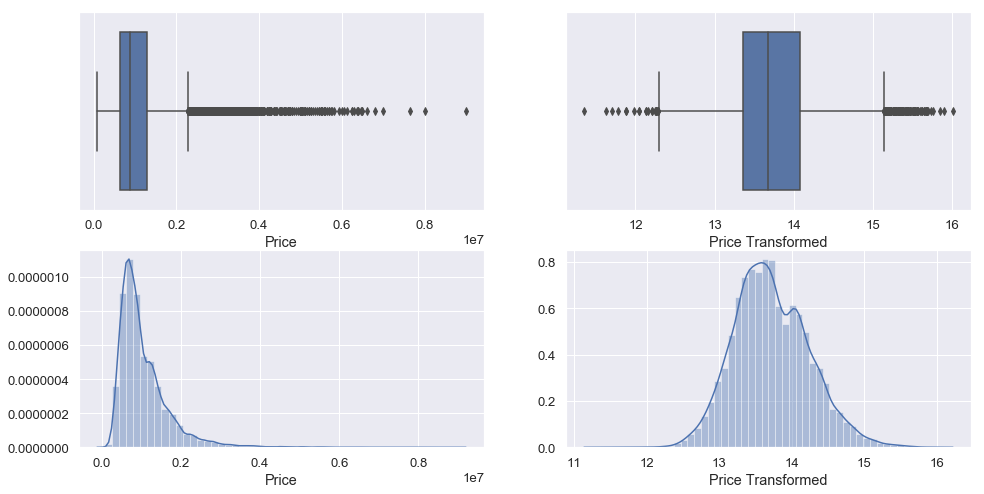

In [59]:
# log-transformed values seem normally distributed
fig, axes = plt.subplots(2, 2)
column = 'Price'
column_lessthan = 10000000
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0])
sns.boxplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1])
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [60]:
top_prices = df.sort_values(by='Price', ascending=False).head(100)

In [61]:
# top 100 expensive properties
# most are along the coastline or in the center of melbourne
gv.tile_sources.Wikipedia * top_prices.hvplot.points(
    'Longitude', 'Latitude', geo=True, color='red', height=500, hover=False,
    xlim=(-180, 180), ylim=(-80, 80))

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [62]:
# top 25 expensive properties
# most are still along the coastline or in the center of melbourne
# one point is in neither of those areas
gv.tile_sources.Wikipedia * top_prices.head(25).hvplot.points(
    'Longitude', 'Latitude', geo=True, color='red', height=500, hover=False,
    xlim=(-180, 180), ylim=(-80, 80))

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [63]:
# top 10 expensive properties
# most are in the center of melbourne
# one point is on the coastline
# one point is in neither of those areas
# only 7 points are visible because 3 properties don't have a Latitude or Longitude
gv.tile_sources.Wikipedia * top_prices.head(10).hvplot.points(
    'Longitude', 'Latitude', geo=True, color='red', height=500, hover=False,
    xlim=(-180, 180), ylim=(-80, 80))

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [64]:
top_prices.head(10)[['Latitude', 'Longitude']]

,Latitude,Longitude
25635,-37.89335,144.98643
19583,-37.93168,145.16126
12539,-37.81790,145.06940
15696,-37.82652,145.03052
28334,NaN,NaN
20924,-37.85801,145.01383
30551,-37.84813,145.03193
25204,NaN,NaN
5937,-37.80290,145.02670
16003,NaN,NaN


In [65]:
# top 2 expensive properties
# the most expensive property is on the coastline
# the second most expensive property is the one that wasn't in the center of Melbourne
gv.tile_sources.Wikipedia * top_prices.head(2).hvplot.points(
    'Longitude', 'Latitude', geo=True, color='red', height=500, hover=False,
    xlim=(-180, 180), ylim=(-80, 80))

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [66]:
top_prices.head(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car_Clean,Bedroom2_Incorrect,Bathroom_Incorrect,Car_Incorrect,Landsize_Incorrect,Landsize_Clean,BuildingArea_Incorrect,BuildingArea_Clean,YearBuilt_Incorrect,YearBuilt_Clean
25635,Brighton,6 Cole St,4,h,11200000.0,VB,hockingstuart,28/10/2017,10.5,3186,...,2.0,0,0,0,0,1400.0,0,NaN,0,NaN
19583,Mulgrave,35 Bevis St,3,h,9000000.0,PI,Hall,29/07/2017,18.8,3170,...,1.0,0,0,0,0,744.0,0,117.0,0,1960.0


* [Property 25635](https://www.domain.com.au/property-profile/6-cole-street-brighton-vic-3186) The property was sold through private treaty for 10.7 million, not 11.2 million. Interestingly, the current estimated price for this property is 4.66-5.94 million. 
* [Property 19583](https://www.domain.com.au/property-profile/35-bevis-street-mulgrave-vic-3170) The property was sold through private treaty for 904.4k, not 9 million. Also, the property was sold September 2017, not July 2017.

In [67]:
# correcting the price
df['Price_Clean'] = df['Price']
df['Price_Incorrect'] = 0

df.loc[19583, 'Price_Clean'] = 904400
df.loc[19583, 'Price_Incorrect'] = 1

In [68]:
# the other top 10 properties (which have Latitude and Longitude) are all in the center of Melbourne
gv.tile_sources.Wikipedia * top_prices[2:10].hvplot.points(
    'Longitude', 'Latitude', geo=True, color='red', height=500, hover=False,
    xlim=(-180, 180), ylim=(-80, 80))

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [69]:
top_prices[2:10]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car_Clean,Bedroom2_Incorrect,Bathroom_Incorrect,Car_Incorrect,Landsize_Incorrect,Landsize_Clean,BuildingArea_Incorrect,BuildingArea_Clean,YearBuilt_Incorrect,YearBuilt_Clean
12539,Canterbury,49 Mangarra Rd,5,h,8000000.0,VB,Sotheby's,13/05/2017,9.0,3126,...,4.0,0,0,0,0,2079.0,0,464.3,0,1880.0
15696,Hawthorn,49 Lisson Gr,4,h,7650000.0,S,Abercromby's,17/06/2017,5.3,3122,...,4.0,0,0,0,0,1690.0,0,284.0,0,1863.0
28334,Armadale,1 Barnato Gr,4,h,7000000.0,PI,Kay,25/11/2017,6.3,3143,...,NaN,0,0,0,0,NaN,0,NaN,0,NaN
20924,Armadale,42 Hampden Rd,4,h,6800000.0,VB,Marshall,16/09/2017,6.3,3143,...,2.0,0,0,0,0,NaN,0,NaN,0,NaN
30551,Malvern,6 Moorakyne Av,5,h,6600000.0,S,Jellis,9/12/2017,5.9,3144,...,2.0,0,0,0,0,NaN,0,465.0,0,1940.0
25204,Melbourne,252/350 St Kilda Rd,3,u,6500000.0,VB,Sotheby's,21/10/2017,0.0,3000,...,NaN,0,0,0,0,NaN,0,NaN,0,NaN
5937,Kew,15 Barry St,6,h,6500000.0,S,Jellis,13/08/2016,5.6,3101,...,3.0,0,0,0,0,1334.0,0,365.0,0,1890.0
16003,Toorak,21 Iona Av,4,h,6460000.0,S,RT,17/06/2017,4.1,3142,...,NaN,0,0,0,0,NaN,0,NaN,0,NaN


* [Property 12539](https://www.domain.com.au/property-profile/49-mangarra-road-canterbury-vic-3126) The property has never been listed. I couldn't any listings on any other site either.
* [Property 15696](https://www.domain.com.au/property-profile/49-lisson-grove-hawthorn-vic-3122) The online price matches the value in our dataset.
* [Property 28334](https://www.domain.com.au/property-profile/1-barnato-grove-armadale-vic-3143) The property was sold through private treaty for 6.5 million, not 7 million.
* [Property 20924](https://www.domain.com.au/property-profile/42-hampden-road-armadale-vic-3143) The property was listed but not sold in September 2017.
* [Property 30551](https://www.domain.com.au/property-profile/6-moorakyne-avenue-malvern-vic-3144) The online price matches the value in our dataset.
* [Property 25204](https://www.domain.com.au/property-profile/252-350-st-kilda-road-melbourne-vic-3000) The property was listed but not sold in October 2017.
* [Property 5937](https://www.domain.com.au/property-profile/15-barry-street-kew-vic-3101) The online price matches the value in our dataset.
* [Property 16003](https://www.domain.com.au/property-profile/21-iona-avenue-toorak-vic-3142) The online price matches the value in our dataset.

All the prices for properties that were sold through Method 'S' matched the prices I found online. 3 of the 4 properties sold through Method 'VB' were not actually sold according to domain.com.au. The price for one of the properties sold through Method 'PI' was an order of magnitude less than what it actually sold for.

In [70]:
# 17 more properties in the top 100 were sold through 'VB'
top_prices.loc[top_prices['Method'] == 'VB'][4:].shape

(17, 41)

In [71]:
# 16 more properties in the top 100 were sold through 'PI'
top_prices.loc[top_prices['Method'] == 'PI'][2:].shape

(16, 41)

In [72]:
# examine the next two properties sold through 'PI'
top_prices.loc[top_prices['Method'] == 'PI'][2:].head(2)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Car_Clean,Bedroom2_Incorrect,Bathroom_Incorrect,Car_Incorrect,Landsize_Incorrect,Landsize_Clean,BuildingArea_Incorrect,BuildingArea_Clean,YearBuilt_Incorrect,YearBuilt_Clean
12316,Brighton,161 Church St,5,h,5800000.0,PI,Castran,8/04/2017,11.2,3186,...,4.0,0,0,0,0,1276.0,0,NaN,0,1880.0
27484,Balwyn,16 Boston Rd,4,h,5650000.0,PI,Marshall,18/11/2017,7.9,3103,...,2.0,0,0,0,0,1561.0,0,NaN,0,1915.0


* [Property 12316](https://www.domain.com.au/property-profile/161-church-street-brighton-vic-3186) The online price matches the value in our dataset. There was even an article, [Discounted Brighton mansion sells for more than 6 million](https://www.domain.com.au/news/discounted-brighton-mansion-sells-for-more-than-6-million-20170411-gviixr/).
* [Property 27484](https://www.domain.com.au/property-profile/16-boston-road-balwyn-vic-3103) The closest listing was in June 2018, not November 2017, and the price stated online is 6.5 million, not 5.65 million. I couldn't find a listing closer to November 2017 on any other site.

The prices for properties sold through 'S' seem to be the most dependable, so I will not consider properties sold through 'VB' and 'PI' when training the models.

In [73]:
top_prices = df.loc[~df['Method'].isin(['VB', 'PI']), :].sort_values(by='Price', ascending=False).head(100)

In [74]:
top_prices['Method'].value_counts()

S     94
SP     6
Name: Method, dtype: int64

In [75]:
# examine the top 4 properties sold through 'SP'
top_prices.loc[top_prices['Method'] == 'SP'].head(4)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom_Incorrect,Car_Incorrect,Landsize_Incorrect,Landsize_Clean,BuildingArea_Incorrect,BuildingArea_Clean,YearBuilt_Incorrect,YearBuilt_Clean,Price_Clean,Price_Incorrect
25504,Armadale,25 Munro St,4,h,6050000.0,SP,Marshall,28/10/2017,6.3,3143,...,0,0,0,NaN,0,NaN,0,NaN,6050000.0,0
21310,Kew,5 Stoke Av,5,h,5580000.0,SP,Marshall,16/09/2017,5.4,3101,...,0,0,0,NaN,0,414.0,0,2007.0,5580000.0,0
14236,Armadale,52 Adelaide St,5,h,5200000.0,SP,Marshall,1/07/2017,6.3,3143,...,0,0,0,761.0,0,NaN,0,NaN,5200000.0,0
977,Balwyn,1 Prowse Av,6,h,4600000.0,SP,Philip,26/07/2016,9.7,3103,...,0,0,0,NaN,0,NaN,0,NaN,4600000.0,0


* [Property 25504](https://www.domain.com.au/property-profile/25-munro-street-armadale-vic-3143) The online price matches the value in our dataset.
* [Property 21310](https://www.domain.com.au/property-profile/5-stoke-avenue-kew-vic-3101) The online price matches the value in our dataset.
* [Property 14236](https://www.domain.com.au/property-profile/52-adelaide-street-armadale-vic-3143) The online price matches the value in our dataset.
* [Property 977](https://www.domain.com.au/property-profile/1-prowse-avenue-balwyn-vic-3103) The property was listed but not sold in July 2015, not July 2016. However, a [second source](https://www.realestate.com.au/property/1-prowse-ave-balwyn-vic-3103) matches the Price and Date values in our dataset.

The prices for properties sold through 'SP' also seem dependable. The second source (realestate.com.au) found for Property 977 is one of the data sources that the dataset creator said he scraped from.

In [76]:
# want to see if there are properties sold through 'SA', the last Method
# for which we have properties with Price values
top_prices = df.loc[~df['Method'].isin(['VB', 'PI']), :].sort_values(by='Price', ascending=False).head(500)
top_prices['Method'].value_counts()

S     455
SP     41
SA      4
Name: Method, dtype: int64

In [77]:
# examine the top 4 properties sold through 'SA'
top_prices.loc[top_prices['Method'] == 'SA'].head(4)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom_Incorrect,Car_Incorrect,Landsize_Incorrect,Landsize_Clean,BuildingArea_Incorrect,BuildingArea_Clean,YearBuilt_Incorrect,YearBuilt_Clean,Price_Clean,Price_Incorrect
34496,Middle Park,108 Hambleton St,3,h,3750000.0,SA,Greg,24/02/2018,3.0,3206,...,0,0,0,284.0,0,148.0,0,1890.0,3750000.0,0
2621,Camberwell,1288 Toorak Rd,4,h,3225000.0,SA,RT,3/09/2016,7.8,3124,...,0,0,0,934.0,0,NaN,0,NaN,3225000.0,0
17955,Canterbury,3 Leeds St,4,h,2725000.0,SA,Kay,12/08/2017,8.4,3126,...,0,0,0,650.0,0,275.0,0,2006.0,2725000.0,0
9342,South Yarra,29 Davis Av,3,h,2682000.0,SA,Domain,24/09/2016,3.3,3141,...,0,0,0,NaN,0,NaN,0,NaN,2682000.0,0


* [Property 34496](https://www.domain.com.au/property-profile/108-hambleton-street-middle-park-vic-3206) The online price matches the value in our dataset.
* [Property 2621](https://www.domain.com.au/property-profile/1288-toorak-road-camberwell-vic-3124) The online price matches the value in our dataset.
* [Property 17955](https://www.domain.com.au/property-profile/3-leeds-street-canterbury-vic-3126) The online price matches the value in our dataset.
* [Property 9342](https://www.domain.com.au/property-profile/29-davis-avenue-south-yarra-vic-3141) The online price matches the value in our dataset.

The prices for properties sold through 'SA' also seem dependable. To recap, I will only use properties sold through 'S', 'SP', and 'SA' to train the model for predicting Price.

In [78]:
df.shape

(34856, 43)

In [79]:
# set Price for everything besides 'S', 'SP', 'SA' to NaN to indicate they aren't trustworthy
# will lose Price values for about 1/3 of the dataset
df.loc[~df['Method'].isin(['S', 'SP', 'SA']), :].shape

(9792, 43)

In [80]:
df['Price_Clean'].describe()

count    2.724700e+04
mean     1.049876e+06
std      6.396571e+05
min      8.500000e+04
25%      6.350000e+05
50%      8.700000e+05
75%      1.295000e+06
max      1.120000e+07
Name: Price_Clean, dtype: float64

In [81]:
df.loc[~df['Method'].isin(['S', 'SP', 'SA']), 'Price_Incorrect'] = 1
df.loc[~df['Method'].isin(['S', 'SP', 'SA']), 'Price_Clean'] = np.NaN

In [82]:
# this range of Price values seems more reasonable than before
# there seems to be a low value
df['Price_Clean'].describe()

count    2.130800e+04
mean     1.021687e+06
std      5.999417e+05
min      1.120000e+05
25%      6.350000e+05
50%      8.570000e+05
75%      1.251000e+06
max      7.650000e+06
Name: Price_Clean, dtype: float64

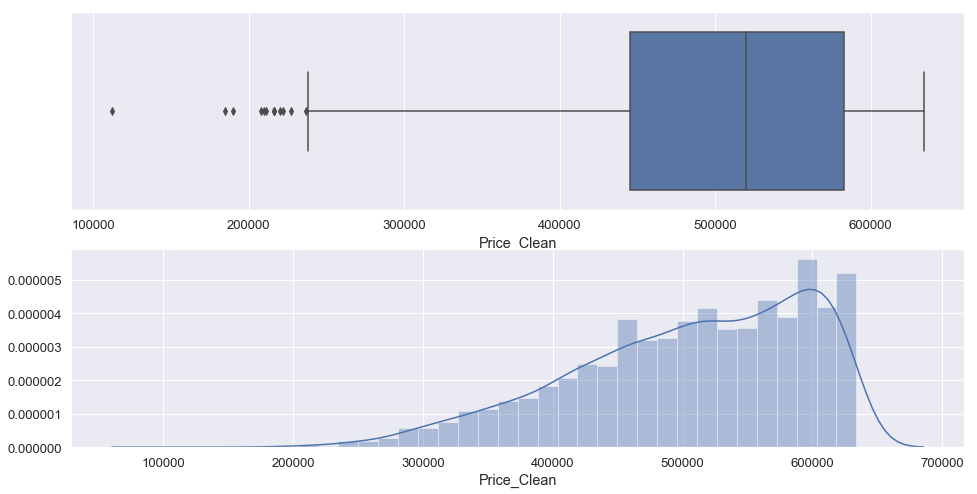

In [83]:
# a few very low values < 200000
fig, axes = plt.subplots(2, 1)
column = 'Price_Clean'
column_lessthan = 635000
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1])
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [84]:
df.loc[df['Price_Clean'] < 250000, ['Address', 'Suburb', 'Postcode', 'Price_Clean', 'SellerG', 'Date',
                              'Rooms', 'Bedroom2', 'Bathroom', 'Car_Clean', 'Method']].sort_values(by='Price_Clean')

,Address,Suburb,Postcode,Price_Clean,SellerG,Date,Rooms,Bedroom2,Bathroom,Car_Clean,Method
29669,114/141 Waverley Rd,Malvern East,3145,112000.0,C21,6/01/2018,1,NaN,NaN,NaN,S
11848,10/117 Anderson Rd,Albion,3020,185000.0,hockingstuart,22/08/2016,1,1.0,1.0,1.0,S
11861,5/25 Ridley St,Albion,3020,190000.0,Burnham,30/07/2016,2,2.0,1.0,1.0,SP
20888,20/697 Barkly St,West Footscray,3012,208000.0,C21,9/09/2017,1,1.0,1.0,1.0,S
11588,2/57 Kingsville St,Kingsville,3012,210000.0,Jas,18/03/2017,1,1.0,1.0,1.0,S
9505,3/239 Canterbury Rd,St Kilda,3182,211000.0,Gary,6/08/2016,1,NaN,NaN,NaN,S
4385,2/3 Eldridge St,Footscray,3011,216000.0,Sweeney,4/02/2016,1,1.0,1.0,1.0,S
8619,1/164 Leamington St,Reservoir,3073,216000.0,Brad,24/09/2016,1,2.0,1.0,1.0,S
19532,5/35 Kingsville St,Kingsville,3012,216000.0,Jas,29/07/2017,1,1.0,1.0,1.0,SP
8620,2/164 Leamington St,Reservoir,3073,220000.0,Brad,24/09/2016,1,1.0,1.0,1.0,S


* [Property 29669](https://www.domain.com.au/property-profile/114-141-waverley-road-malvern-east-vic-3145) One sale found in March 2004 for 183,000.
* [Property 11848](https://www.domain.com.au/property-profile/10-117-anderson-road-albion-vic-3020) Price matches.

Since the lowest valid Price found is for 185000, I will assume that Prices < 185000 are incorrect.

In [85]:
df['Price_Clean'].describe()

count    2.130800e+04
mean     1.021687e+06
std      5.999417e+05
min      1.120000e+05
25%      6.350000e+05
50%      8.570000e+05
75%      1.251000e+06
max      7.650000e+06
Name: Price_Clean, dtype: float64

In [86]:
# this property's price is unlikely to be correct
df.loc[df['Price_Clean'] < 185000, :].shape

(1, 43)

In [87]:
# replace incorrect building area values with NaN
df.loc[df['Price_Clean'] < 185000, 'Price_Incorrect'] = 1
df.loc[df['Price_Clean'] < 185000, 'Price_Clean'] = np.NaN

In [88]:
# values have been set to NaN
df['Price_Clean'].describe()

count    2.130700e+04
mean     1.021730e+06
std      5.999234e+05
min      1.850000e+05
25%      6.350000e+05
50%      8.570000e+05
75%      1.251000e+06
max      7.650000e+06
Name: Price_Clean, dtype: float64

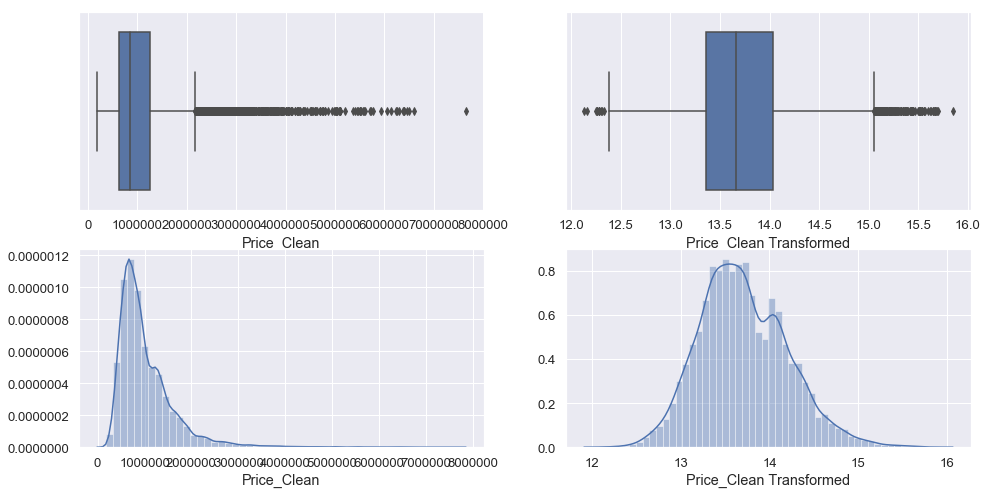

In [89]:
# still right skewed
fig, axes = plt.subplots(2, 2)
column = 'Price_Clean'
column_lessthan = 10000000
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0])
sns.boxplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1])
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

The log-transformed Price values are approximately normal.

##### Distance
This feature is "Distance from CBD in Kilometres".

In [90]:
df['Distance'].describe()

count    34855.000000
mean        11.184808
std          6.788952
min          0.000000
25%          6.400000
50%         10.300000
75%         14.000000
max         48.100000
Name: Distance, dtype: float64

In [91]:
farthest = df.sort_values(by='Distance', ascending=False).head(100)

In [92]:
# top 100 farthest properties
# they are very far from the center, and are 
# all about the same distance from the center
gv.tile_sources.Wikipedia * farthest.hvplot.points(
    'Longitude', 'Latitude', geo=True, color='red', height=500, hover=False,
    xlim=(-180, 180), ylim=(-80, 80))

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

The high values for distance seem reasonable.

##### Rooms
This feature is "Number of rooms". From the previous notebook we know it is actually the number of bedrooms and represents the same thing as the Bedroom2 feature.

In [93]:
df['Rooms'].describe()

count    34856.000000
mean         3.031013
std          0.969947
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: Rooms, dtype: float64

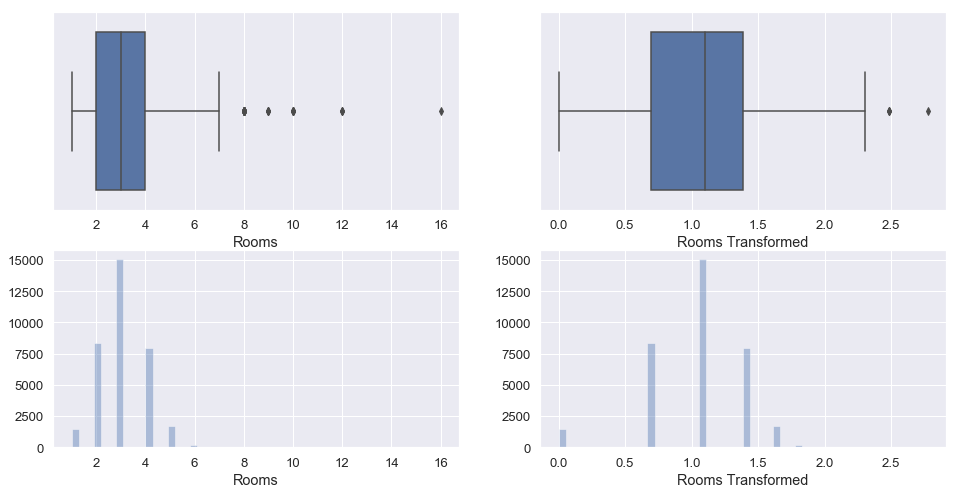

In [94]:
# log-transformed values seem normally distributed
fig, axes = plt.subplots(2, 2)
column = 'Rooms'
column_lessthan = 20
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0], kde=False)
sns.boxplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1], kde=False)
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [95]:
df['Rooms'].value_counts().sort_index()

1      1479
2      8332
3     15083
4      7956
5      1737
6       204
7        32
8        19
9         4
10        6
12        3
16        1
Name: Rooms, dtype: int64

In [96]:
# examining top 4 properties with most rooms
df.loc[df['Rooms'] > 10]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom_Incorrect,Car_Incorrect,Landsize_Incorrect,Landsize_Clean,BuildingArea_Incorrect,BuildingArea_Clean,YearBuilt_Incorrect,YearBuilt_Clean,Price_Clean,Price_Incorrect
8309,Preston,12 Lyonsville Av,12,h,NaN,SN,Barry,28/08/2016,8.8,3072,...,0,0,0,NaN,0,NaN,0,NaN,NaN,1
12959,Hawthorn,10 Berkeley St,12,h,4700000.0,PI,Property,20/05/2017,4.6,3122,...,0,0,0,NaN,0,NaN,0,NaN,NaN,1
26210,Mitcham,20 Harrison St,16,h,5000000.0,S,Buxton,28/10/2017,17.2,3132,...,0,0,0,NaN,0,NaN,0,NaN,5000000.0,0
27150,Melton,213 Station Rd,12,h,710000.0,S,PRDNationwide,11/11/2017,31.7,3337,...,0,0,0,960.0,0,223.0,0,1970.0,710000.0,0


* Property 8309 I couldn't find this exact address on domain.com.au, but I did find multiple listings for individual units at this address. This listing might represent the entire building, which is why it has 12 rooms.
* [Property 12959](https://www.domain.com.au/building-profile/10-berkeley-street-hawthorn-vic-3122) I found the listing for the entire building, it has several units and 12 rooms in total. 
* Property 26210 I couldn't find this exact address on domain.com.au, but I did find multiple listings for individual units at this address. A [second source](https://www.realestate.com.au/sold/property-house-vic-mitcham-126513794) states this building contains 8 units with 2 bedrooms each, which agrees with the 16 rooms recorded in our dataset. The price from this source also agrees with the price in our dataset.
* Property 27150 I couldn't find this exact address on domain.com.au, but I did find multiple listings for individual units at this address. A [second source](https://www.realestate.com.au/sold/property-house-vic-melton-126591930) states this building contains multiple units and 12 bedrooms in total. The price from this source also agrees with the price in our dataset.

All these listings and high room values seem correct because they are for the entire building and not just one unit.

In [97]:
# properties that are units but have high room values
df.loc[(df['Rooms'] > 4) & (df['Type'] == 'u')]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom_Incorrect,Car_Incorrect,Landsize_Incorrect,Landsize_Clean,BuildingArea_Incorrect,BuildingArea_Clean,YearBuilt_Incorrect,YearBuilt_Clean,Price_Clean,Price_Incorrect
3288,Coburg,35 The Grove,8,u,2250000.0,PI,Peter,4/03/2017,7.8,3058,...,0,0,0,983.0,0,NaN,0,NaN,NaN,1
7590,Parkville,42 Park Dr,8,u,3210000.0,S,Kelly,10/12/2016,2.6,3052,...,0,0,0,NaN,0,NaN,0,NaN,3210000.0,0
9346,South Yarra,15 Clowes St,6,u,NaN,SN,hockingstuart,25/02/2017,3.3,3141,...,0,0,0,NaN,0,NaN,0,NaN,NaN,1
10484,Toorak,508 Toorak Rd,6,u,NaN,S,Kay,22/05/2016,4.6,3142,...,0,0,1,NaN,0,NaN,0,NaN,NaN,0
11767,West Footscray,1/12 Hatfield Ct,6,u,520000.0,SP,Sweeney,7/05/2016,8.2,3012,...,0,0,1,NaN,0,171.0,0,1970.0,520000.0,0
20442,Carnegie,2/3 Libna St,5,u,NaN,S,Jellis,9/09/2017,10.1,3163,...,0,0,0,NaN,0,NaN,0,2012.0,NaN,0
22617,Mount Waverley,1/17 Pamela St,6,u,NaN,PI,Stockdale,23/09/2017,14.2,3149,...,0,0,0,NaN,0,186.0,0,1972.0,NaN,1


* [Property 3288](https://www.realestate.com.au/sold/property-house-vic-coburg-124612374) This is a house.
* [Property 7590](https://www.realestate.com.au/sold/property-house-vic-parkville-124098246) This is an entire apartment block (aka house).
* [Property 9346](https://www.realestate.com.au/sold/property-house-vic-south+yarra-124600430) This is a house.
* [Property 10484](https://www.realestate.com.au/sold/property-apartment-vic-toorak-122528942) This is a duplex, which is correctly typed as 'u'.
* [Property 11767](https://www.realestate.com.au/sold/property-unit-vic-west+footscray-122347794) This is a unit, but it only has 4 rooms.
* [Property 20442](https://www.realestate.com.au/sold/property-townhouse-vic-carnegie-126191034) This is a townhouse, which should be typed as 't'.
* [Property 22617](https://www.realestate.com.au/sold/property-house-vic-mount+waverley-105981703) This is a house, even though there is a slash in the adrress which should indicate it is not a house.

Only two out of seven properties were correctly typed as 'u', and one of these properties had an incorrect value for Rooms recorded in the dataset.

In [98]:
# fix the values
df['Type_Clean'] = df['Type']
df['Type_Incorrect'] = 0
df.loc[[3288, 7590, 9346, 22617, 20442], 'Type_Incorrect'] = 1
df.loc[[3288, 7590, 9346, 22617], 'Type_Clean'] = 'h'
df.loc[20442, 'Type_Clean'] = 't'


df['Rooms_Clean'] = df['Rooms']
df['Rooms_Incorrect'] = 0
df.loc[11767, 'Rooms_Incorrect'] = 1
df.loc[11767, 'Rooms_Clean'] = 4

In [99]:
# how many units have 4 rooms
df.loc[df['Rooms_Clean'] == 4, 'Type'].value_counts()

h    7274
t     621
u      62
Name: Type, dtype: int64

Since I did find a property that was a unit with 4 rooms, it's reasonable to assume the other 4-room units are correct.

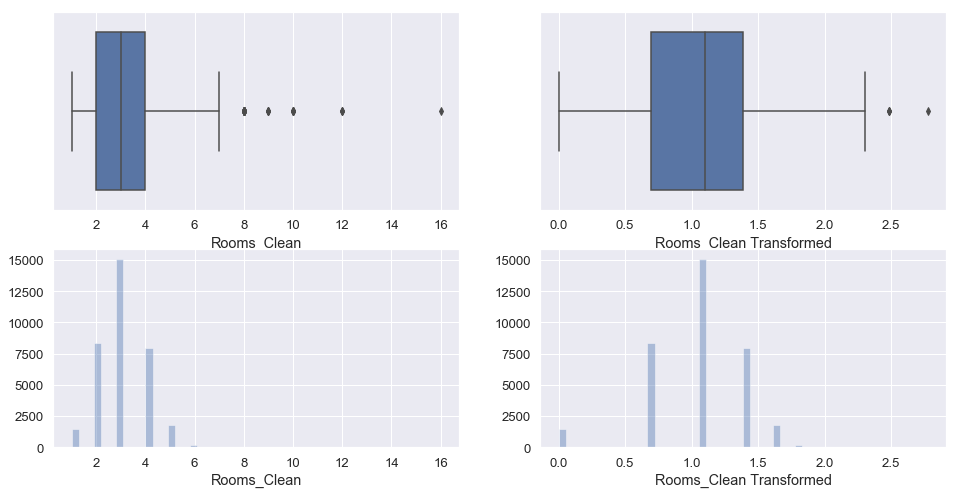

In [100]:
# log-transformed values seem normally distributed
fig, axes = plt.subplots(2, 2)
column = 'Rooms_Clean'
column_lessthan = 20
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0], kde=False)
sns.boxplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1], kde=False)
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

##### Bedroom2
This feature is "Scraped # of Bedrooms (from different source)". From the previous notebook we know it represents the same thing as the Rooms feature.

In [101]:
df['Bedroom2_Clean'].describe()

count    26626.000000
mean         3.086532
std          0.977889
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         30.000000
Name: Bedroom2_Clean, dtype: float64

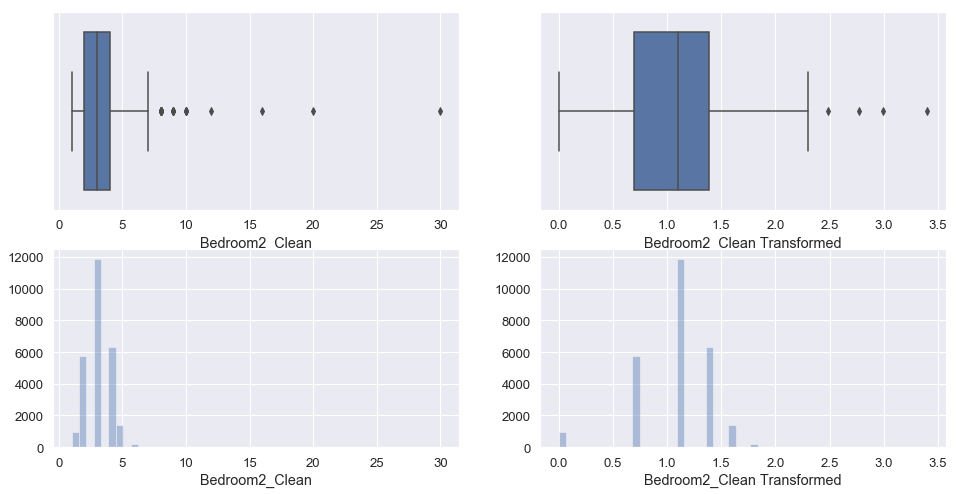

In [102]:
# log-transformed values seem normally distributed
fig, axes = plt.subplots(2, 2)
column = 'Bedroom2_Clean'
column_lessthan = 35
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0], kde=False)
sns.boxplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1], kde=False)
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [103]:
df['Bedroom2_Clean'].value_counts().sort_index()

1.0       966
2.0      5779
3.0     11882
4.0      6348
5.0      1427
6.0       168
7.0        30
8.0        13
9.0         5
10.0        4
12.0        1
16.0        1
20.0        1
30.0        1
Name: Bedroom2_Clean, dtype: int64

In [104]:
# examining top properties with most bedrooms
# Rooms and Bedroom2 agree or are off by 1 for seven of the thirteen properties
df.loc[df['Bedroom2_Clean'] > 8, ['Rooms_Clean', 'Bedroom2_Clean']]

,Rooms_Clean,Bedroom2_Clean
616,8,9.0
1640,10,9.0
2536,3,30.0
8251,4,9.0
11270,3,9.0
12043,3,20.0
18443,10,10.0
21569,9,9.0
25717,10,10.0
26210,16,16.0


In [105]:
#### examining top properties with most bedrooms and
# disagreeing values for Rooms and Bedrooms2 (difference in values > 1)
df.loc[(df['Bedroom2_Clean'] > 6) & (np.abs(df['Bedroom2_Clean'] - df['Rooms']) > 1),
       ['Rooms_Clean', 'Bedroom2_Clean', 'Bathroom_Clean', 'Car_Clean', 'Type_Clean',
        'Address', 'Suburb', 'Postcode', 'Price_Clean', 'SellerG', 'Date_Clean']]

,Rooms_Clean,Bedroom2_Clean,Bathroom_Clean,Car_Clean,Type_Clean,Address,Suburb,Postcode,Price_Clean,SellerG,Date_Clean
390,5,8.0,2.0,2.0,h,553 Dandenong Rd,Armadale,3143,NaN,Jellis,2016-05-07
1187,5,7.0,2.0,0.0,h,30 Abbott St,Balwyn North,3104,NaN,Fletchers,2016-05-28
2536,3,30.0,12.0,0.0,h,36 Cumming St,Burwood,3125,NaN,Ross,2016-10-08
8251,4,9.0,8.0,7.0,h,421 Murray Rd,Preston,3072,NaN,Barry,2016-05-22
11270,3,9.0,6.0,2.0,h,39 Lynch Rd,Fawkner,3060,751000.0,Stockdale,2016-09-17
12043,3,20.0,1.0,2.0,h,5 Grange Rd,Caulfield East,3145,NaN,Woodards,2016-08-06
27390,4,10.0,6.0,7.0,h,440 Burwood Hwy,Vermont South,3133,1600000.0,Buxton,2017-11-11
27391,3,10.0,6.0,7.0,h,442 Burwood Hwy,Vermont South,3133,1600000.0,Buxton,2017-11-11


* [Property 390](https://www.domain.com.au/property-profile/553-dandenong-road-armadale-vic-3143) It has 5 bedrooms.
* [Property 1187](https://www.domain.com.au/property-profile/30-abbott-street-balwyn-north-vic-3104) It has 4 bedrooms, 1 bathroom, and 1 parking.
* [Property 2536](https://www.domain.com.au/property-profile/36-cumming-street-burwood-vic-3125) I could only find a listing for one unit within the property and not the entire building. It has 3 bedrooms, 2 bathrooms, 2 parking.
* [Property 8251](https://www.realestate.com.au/property/421-murray-rd-preston-vic-3072) It has 9 bedrooms, 0 bathrooms, and 2 car spots. However, there is no history of the property being sold.
* [Property 11270](https://www.realestate.com.au/sold/property-townhouse-vic-fawkner-128856574) It has 3 bedrooms, 3 bathrooms, and 2 car spots.
* [Property 12043](https://www.domain.com.au/property-profile/5-grange-road-caulfield-east-vic-3145) It has 5 bedrooms, 1 bathroom, and 2 car spots. However, the site doesn't have a record of it being sold near August 2016.
* [Property 27390](https://www.realestate.com.au/property/440-burwood-hwy-vermont-south-vic-3133) It has 4 bedrooms, 3 bathrooms, and 2 car spots.
* [Property 27391](https://www.realestate.com.au/property/442-burwood-hwy-vermont-south-vic-3133) It has 3 bedrooms, 2 bathrooms, and 3 car spots.

The value for Rooms is more accurate than the Bedroom2 value for most of these properties. The Bedroom2 value was accurate for property 8251, but I couldn't find any record of this property's listing. Since we don't care about its price, I'll just drop it.

In [106]:
# correct the Bedroom2 values by using Rooms
use_rooms = df.loc[(df['Bedroom2_Clean'] > 6) & (np.abs(df['Bedroom2_Clean'] - df['Rooms']) > 1), :].index
df.loc[use_rooms, 'Bedroom2_Incorrect'] = 1
df.loc[use_rooms, 'Bedroom2_Clean'] = df.loc[use_rooms, 'Rooms']

In [107]:
def correct_value(index, column, value):    
    df.loc[index, column+'_Clean'] = value
    df.loc[index, column+'_Incorrect'] = 1

In [108]:
# correct the Bathroom and Car values
correct_value(1187, 'Bathroom', 1)
correct_value(1187, 'Car', 1)
correct_value(2536, 'Bathroom', 2)
correct_value(2536, 'Car', 2)
correct_value(11270, 'Bathroom', 3)
correct_value(27390, 'Bathroom', 3)
correct_value(27390, 'Car', 2)
correct_value(27391, 'Bathroom', 2)
correct_value(27391, 'Car', 3)

In [109]:
# values successfully updated
df.loc[use_rooms,
       ['Rooms_Clean', 'Bedroom2_Clean', 'Bathroom_Clean', 'Car_Clean', 'Type_Clean',
        'Address', 'Suburb', 'Postcode', 'Price_Clean', 'SellerG', 'Date_Clean']]

,Rooms_Clean,Bedroom2_Clean,Bathroom_Clean,Car_Clean,Type_Clean,Address,Suburb,Postcode,Price_Clean,SellerG,Date_Clean
390,5,5.0,2.0,2.0,h,553 Dandenong Rd,Armadale,3143,NaN,Jellis,2016-05-07
1187,5,5.0,1.0,1.0,h,30 Abbott St,Balwyn North,3104,NaN,Fletchers,2016-05-28
2536,3,3.0,2.0,2.0,h,36 Cumming St,Burwood,3125,NaN,Ross,2016-10-08
8251,4,4.0,8.0,7.0,h,421 Murray Rd,Preston,3072,NaN,Barry,2016-05-22
11270,3,3.0,3.0,2.0,h,39 Lynch Rd,Fawkner,3060,751000.0,Stockdale,2016-09-17
12043,3,3.0,1.0,2.0,h,5 Grange Rd,Caulfield East,3145,NaN,Woodards,2016-08-06
27390,4,4.0,3.0,2.0,h,440 Burwood Hwy,Vermont South,3133,1600000.0,Buxton,2017-11-11
27391,3,3.0,2.0,3.0,h,442 Burwood Hwy,Vermont South,3133,1600000.0,Buxton,2017-11-11


In [110]:
# drop the listing which I couldn't find online
df = df.drop(8251, axis=0)

In [111]:
df[['Rooms_Clean', 'Bedroom2_Clean']].describe()

,Rooms_Clean,Bedroom2_Clean
count,34855.000000,26625.000000
mean,3.030928,3.083756
std,0.969830,0.954439
min,1.000000,1.000000
25%,2.000000,2.000000
50%,3.000000,3.000000
75%,4.000000,4.000000
max,16.000000,16.000000


Bedroom2 is very similar to Rooms now, which is good because they represent the same thing.

##### Bathroom
This feature is "Number of Bathrooms".

In [112]:
df['Bathroom_Clean'].describe()

count    26590.000000
mean         1.626439
std          0.716352
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          9.000000
Name: Bathroom_Clean, dtype: float64

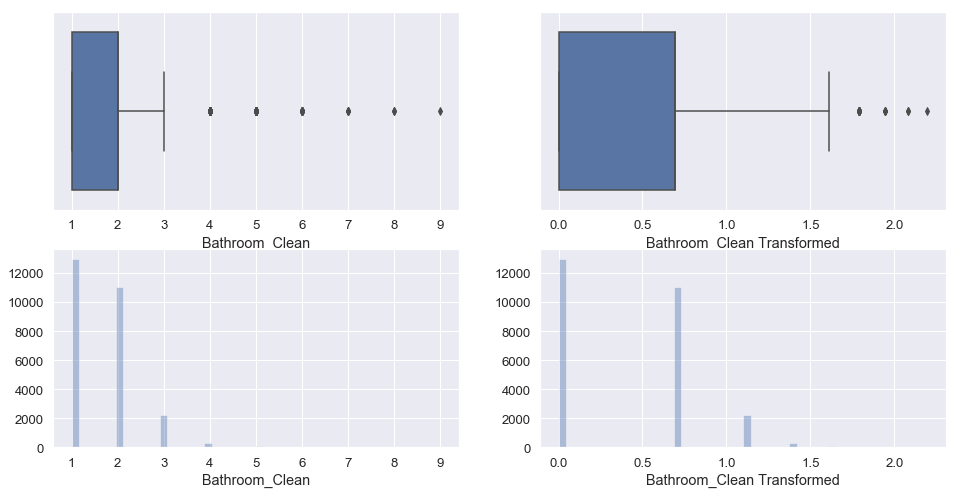

In [113]:
# log-transformed values doesn't seem normally distributed
fig, axes = plt.subplots(2, 2)
column = 'Bathroom_Clean'
column_lessthan = 10
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0], kde=False)
sns.boxplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1], kde=False)
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [114]:
df['Bathroom_Clean'].value_counts().sort_index()

1.0    12975
2.0    11067
3.0     2182
4.0      269
5.0       77
6.0       13
7.0        4
8.0        2
9.0        1
Name: Bathroom_Clean, dtype: int64

In [115]:
# examining top properties with most bathrooms
df.loc[(df['Bathroom_Clean'] > 5), ['Rooms_Clean', 'Bedroom2_Clean', 'Bathroom_Clean']]

,Rooms_Clean,Bedroom2_Clean,Bathroom_Clean
175,7,7.0,7.0
616,8,9.0,7.0
947,5,5.0,6.0
1004,5,5.0,7.0
1860,3,5.0,6.0
5937,6,6.0,6.0
17472,8,8.0,8.0
17531,5,5.0,6.0
25096,8,8.0,6.0
25717,10,10.0,9.0


The number of bathrooms compared to the number of bedrooms in the property seems reasonable.

##### Car
This feature is "Number of carspots".

In [116]:
df['Car_Clean'].describe()

count    26127.000000
mean         1.728901
std          1.008667
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         26.000000
Name: Car_Clean, dtype: float64

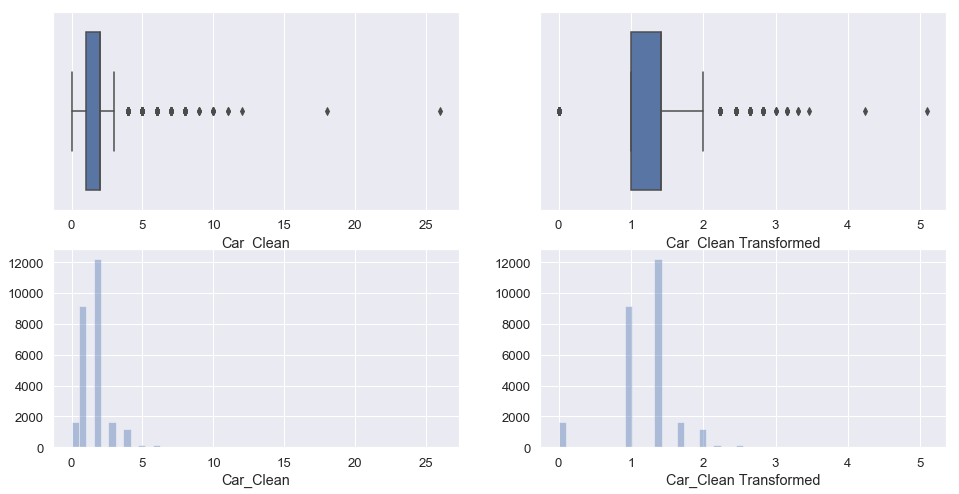

In [117]:
# sqrt-transformed values seems normally distributed
fig, axes = plt.subplots(2, 2)
column = 'Car_Clean'
column_lessthan = 27
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0], kde=False)
sns.boxplot(np.sqrt(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.sqrt(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1], kde=False)
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [118]:
df['Car_Clean'].value_counts().sort_index()

0.0      1619
1.0      9172
2.0     12218
3.0      1607
4.0      1161
5.0       151
6.0       140
7.0        22
8.0        23
9.0         3
10.0        6
11.0        2
12.0        1
18.0        1
26.0        1
Name: Car_Clean, dtype: int64

In [119]:
# examining top properties with most bathrooms
top_cars = df.loc[(df['Car_Clean'] > 8), :].sort_values(by='Car_Clean', ascending=False).index

In [120]:
# examining top properties with most bathrooms
df.loc[top_cars,
       ['Rooms_Clean', 'Bedroom2_Clean', 'Bathroom_Clean', 'Car_Clean', 'Type_Clean',
        'Address', 'Suburb', 'Postcode', 'Price_Clean', 'SellerG', 'Date_Clean']]

,Rooms_Clean,Bedroom2_Clean,Bathroom_Clean,Car_Clean,Type_Clean,Address,Suburb,Postcode,Price_Clean,SellerG,Date_Clean
6017,2,2.0,2.0,26.0,h,25 Duke St,Kew,3101,NaN,Kay,2016-09-24
25839,2,2.0,1.0,18.0,h,26 Railway Cr,Croydon,3136,1105000.0,iTRAK,2017-10-28
31864,5,5.0,5.0,12.0,h,23 Duke St,Kew,3101,NaN,Marshall,2018-03-03
4324,5,4.0,2.0,11.0,h,416 Queens Pde,Fitzroy North,3068,NaN,Collins,2016-08-28
32862,4,4.0,2.0,11.0,h,11 Magnus St,St Albans,3021,788000.0,Ray,2018-02-17
15449,4,4.0,1.0,10.0,h,95 Orange Gr,Bayswater,3153,925000.0,Biggin,2017-06-17
18923,3,3.0,2.0,10.0,h,1462 Heatherton Rd,Dandenong,3175,880000.0,Barry,2017-07-22
23395,4,4.0,2.0,10.0,h,1 Don St,Reservoir,3073,1112000.0,RW,2017-08-26
27882,6,6.0,3.0,10.0,h,62 Cowans Rd,Hopetoun Park,3340,NaN,RT,2017-11-18
29910,5,5.0,2.0,10.0,h,47 Bardsley St,Sunshine West,3020,NaN,Douglas,2018-01-06


The number of bathrooms compared to the number of bedrooms in the property seems reasonable.

* [Property 6017](https://www.realestate.com.au/sold/property-house-vic-kew-123454710) Has 1 car spot, not 26.
* [Property 25839](https://www.realestate.com.au/sold/property-house-vic-croydon-126611422) Actually has 18 car spots.
> Yes... you have NOT misread, offering 18 spaces for undercover vehicle storage.
* [Property 32862](https://www.realestate.com.au/sold/property-house-vic-st+albans-127325110) Has 11 car spots.

Since there is a property with 18 car spots, I'm going to say the rest of the properties can resonably have 11 or fewer.

In [121]:
# fix value for property 6017
correct_value(6017, column='Car', value=1)

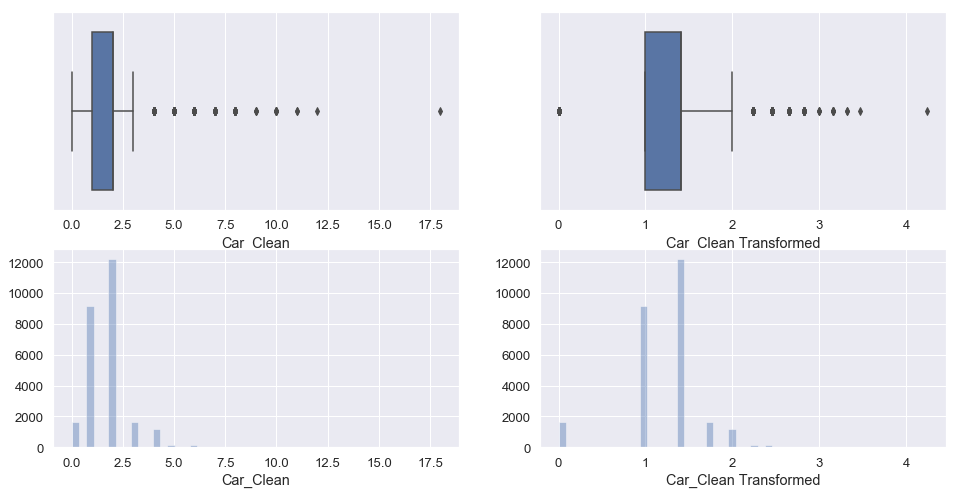

In [122]:
# sqrt-transformed values seems normally distributed
fig, axes = plt.subplots(2, 2)
column = 'Car_Clean'
column_lessthan = 27
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0], kde=False)
sns.boxplot(np.sqrt(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.sqrt(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1], kde=False)
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [123]:
df['Car_Clean'].describe()

count    26127.000000
mean         1.727944
std          0.997437
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         18.000000
Name: Car_Clean, dtype: float64

##### Landsize
This feature is "Land Size in Metres".

In [124]:
df['Landsize_Clean'].describe()

count     20593.00000
mean        664.24790
std        3589.13076
min          29.00000
25%         306.00000
50%         557.00000
75%         692.00000
max      433014.00000
Name: Landsize_Clean, dtype: float64

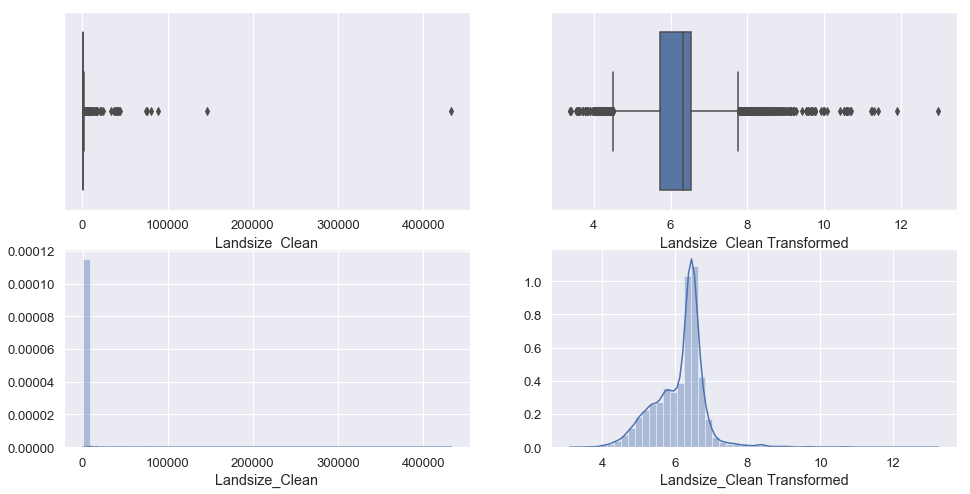

In [125]:
# log-transformed values seem like they could be made up of two normal distributions
# one property has a much larger landsize than all the others
fig, axes = plt.subplots(2, 2)
column = 'Landsize_Clean'
column_lessthan = 500000
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0])
sns.boxplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1])
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [126]:
df.loc[df['Landsize_Clean'] == 433014]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,BuildingArea_Incorrect,BuildingArea_Clean,YearBuilt_Incorrect,YearBuilt_Clean,Price_Clean,Price_Incorrect,Type_Clean,Type_Incorrect,Rooms_Clean,Rooms_Incorrect
18036,Fitzroy,389 Gore St,3,h,2700000.0,VB,Kay,12/08/2017,2.1,3065,...,0,NaN,0,NaN,NaN,1,h,0,3,0


[Property 18036](https://www.realestate.com.au/property/389-gore-st-fitzroy-vic-3065) Landsize is actually 107.

In [127]:
# correct landsize
correct_value(18036, column='Landsize', value=107)

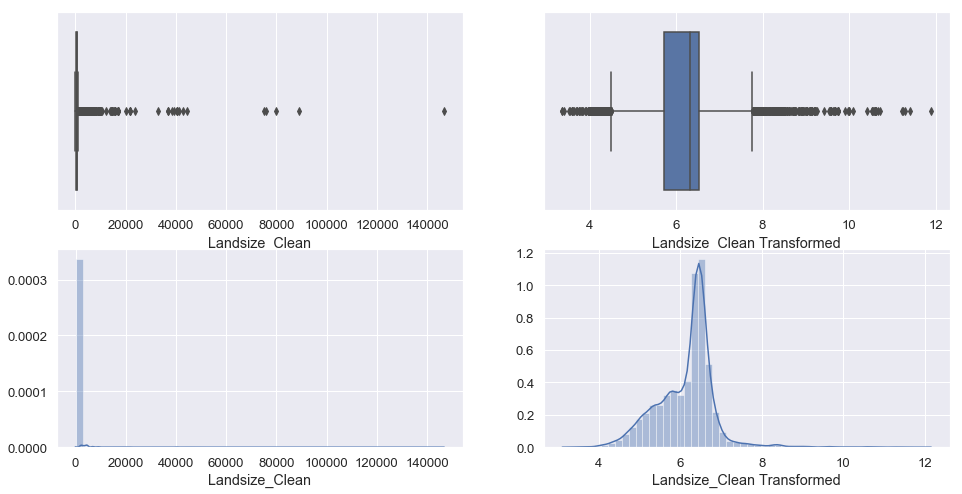

In [128]:
# log-transformed values seem like they could be made up of two normal distributions
# one property has a much larger landsize than all the others
fig, axes = plt.subplots(2, 2)
column = 'Landsize_Clean'
column_lessthan = 500000
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0])
sns.boxplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1])
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

The [analysis](https://chartingtransport.com/2016/05/22/are-melbourne-suburbs-full-of-quarter-acre-blocks/) of land sizes from 2016 lists suburbs which contain large block sizes, so I'll look for the largest valid land size among properties in those suburbs.

In [129]:
biggest_landsizes = ['Park Orchards', 'Selby', 'Warrandyte', 'Mount Eliza', 'Frankston South',
                     'Langwarrin South', 'Langwarrin', 'Mooroolbark', 'Rye', 'Ferntree Gully',
                    'Boronia', 'Croydon', 'Mount Martha', 'Eltham', 'Werribee', 'Sunbury',
                     'Lilydale', 'Mornington', 'Reservoir', 'Balwyn North', 'Berwick', 'Upwey',
                    'Pakenham', 'Kilsyth', 'Greensborough']

In [130]:
df.loc[df['Suburb'].isin(biggest_landsizes), 'Suburb'].value_counts()

Reservoir          844
Balwyn North       420
Werribee           178
Sunbury            157
Greensborough      142
Croydon            133
Eltham              91
Ferntree Gully      70
Mooroolbark         62
Boronia             55
Frankston South     51
Berwick             47
Kilsyth             22
Pakenham            20
Langwarrin          18
Warrandyte          14
Lilydale             7
Upwey                2
Name: Suburb, dtype: int64

In [131]:
# examining the largest recorded land sizes for the suburbs with the largest land sizes
df.loc[df['Suburb'].isin(biggest_landsizes),
       ['Landsize_Clean', 'BuildingArea_Clean', 'Address', 'Suburb', 'Postcode',
        'Price_Clean', 'SellerG', 'Date_Clean']].sort_values(by='Landsize_Clean', ascending=False).head()

,Landsize_Clean,BuildingArea_Clean,Address,Suburb,Postcode,Price_Clean,SellerG,Date_Clean
1198,75100.0,NaN,9 Gildan St,Balwyn North,3104,NaN,Kay,2016-08-28
8599,41400.0,NaN,14 Beenak St,Reservoir,3073,572000.0,Ray,2016-04-23
29653,10120.0,116.0,20 Raneen Dr,Langwarrin,3910,510000.0,Bowman,2018-01-06
16265,4780.0,NaN,160 Overport Rd,Frankston South,3199,860000.0,O'Brien,2017-06-24
27403,4735.0,411.0,11 Clematis Ct,Warrandyte,3113,NaN,Fletchers,2017-11-11


* [Property 1198](https://www.realestate.com.au/property/9-gildan-st-balwyn-north-vic-3104) land: 706, not 75100
* [Property 8599](https://www.domain.com.au/property-profile/14-beenak-street-reservoir-vic-3073) land: 533, not 41400
* [Property 29653](https://www.realestate.com.au/property/20-raneen-dr-langwarrin-vic-3910) land: 335, not 10120
* [Property 16265](https://www.realestate.com.au/property/160-overport-rd-frankston-south-vic-3199) Land size matches.
* [Property 27403](https://www.realestate.com.au/property/11-clematis-ct-warrandyte-vic-3113) Land size matches.

The highest valid land size I found was 4780, so I will assume all the land sizes above 4780 are incorrect.

In [132]:
df['Landsize_Clean'].describe()

count     20593.000000
mean        643.225853
std        1950.337106
min          29.000000
25%         306.000000
50%         557.000000
75%         692.000000
max      146699.000000
Name: Landsize_Clean, dtype: float64

In [133]:
# will lose landsizes for 110 properties
df.loc[df['Landsize_Clean'] > 4780, :].shape

(110, 47)

In [134]:
df.loc[df['Landsize_Clean'] > 4780, 'Landsize_Incorrect'] = 1
df.loc[df['Landsize_Clean'] > 4780, 'Landsize_Clean'] = np.NaN

In [135]:
df['Landsize_Clean'].describe()

count    20483.000000
mean       556.548308
std        407.278669
min         29.000000
25%        306.000000
50%        556.000000
75%        689.000000
max       4780.000000
Name: Landsize_Clean, dtype: float64

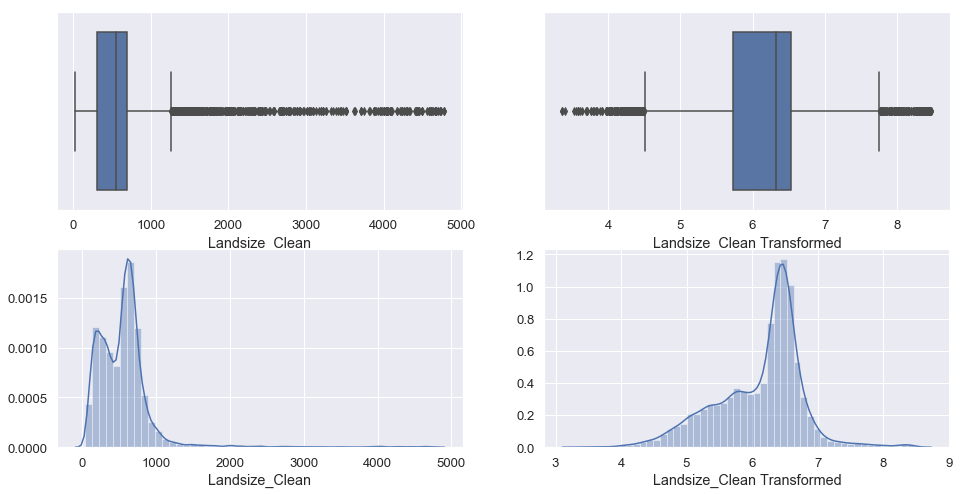

In [136]:
# log-transformed values seem like they could be made up of two normal distributions
fig, axes = plt.subplots(2, 2)
column = 'Landsize_Clean'
column_lessthan = 5000
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0])
sns.boxplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1])
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

The range for the cleaned Landsize values seems more reasonable than before.

##### BuildingArea
This feature is "Building Size in Metres".

In [137]:
df['BuildingArea_Clean'].describe()

count    13578.000000
mean       162.128108
std        403.307835
min         16.000000
25%        103.000000
50%        137.000000
75%        189.000000
max      44515.000000
Name: BuildingArea_Clean, dtype: float64

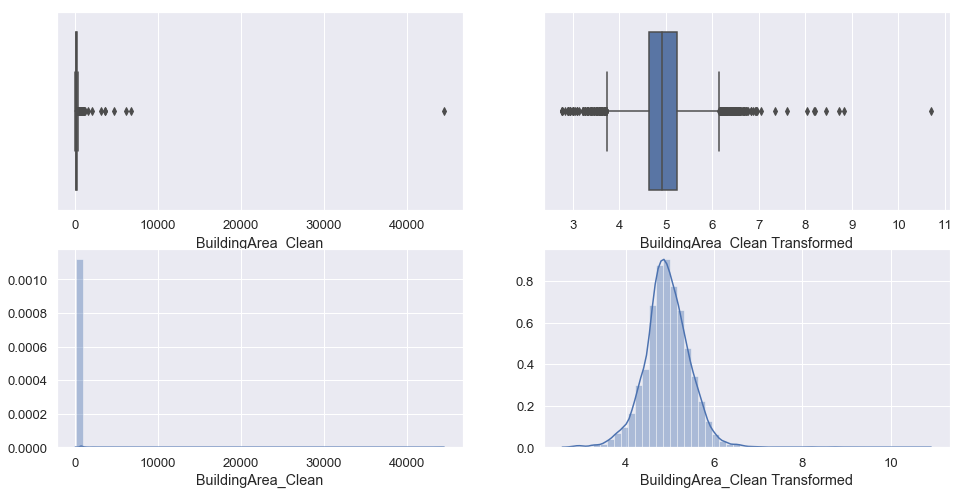

In [138]:
# log-transformed values look normally distributed
# one property has a much larger building area than all the others
fig, axes = plt.subplots(2, 2)
column = 'BuildingArea_Clean'
column_lessthan = 50000
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0])
sns.boxplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1])
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

In [139]:
df.loc[df['BuildingArea_Clean'] == 44515]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,BuildingArea_Incorrect,BuildingArea_Clean,YearBuilt_Incorrect,YearBuilt_Clean,Price_Clean,Price_Incorrect,Type_Clean,Type_Incorrect,Rooms_Clean,Rooms_Incorrect
22632,New Gisborne,71 Hamilton Rd,5,h,1355000.0,S,Raine,23/09/2017,48.1,3438,...,0,44515.0,0,NaN,1355000.0,0,h,0,5,0


[Property 22632](https://www.domain.com.au/property-profile/71-hamilton-road-new-gisborne-vic-3438) The landsize is 40000 and it's a one story house, so the building area of 44515 is unreasonable. However, from our analysis of largest landsizes earlier a land size of 40000 is also unreasonable.

In [140]:
df.loc[22632, 'Landsize_Clean']

nan

In [141]:
# correct values
correct_value(22632, column='Landsize', value=np.NaN)
correct_value(22632, column='BuildingArea', value=np.NaN)

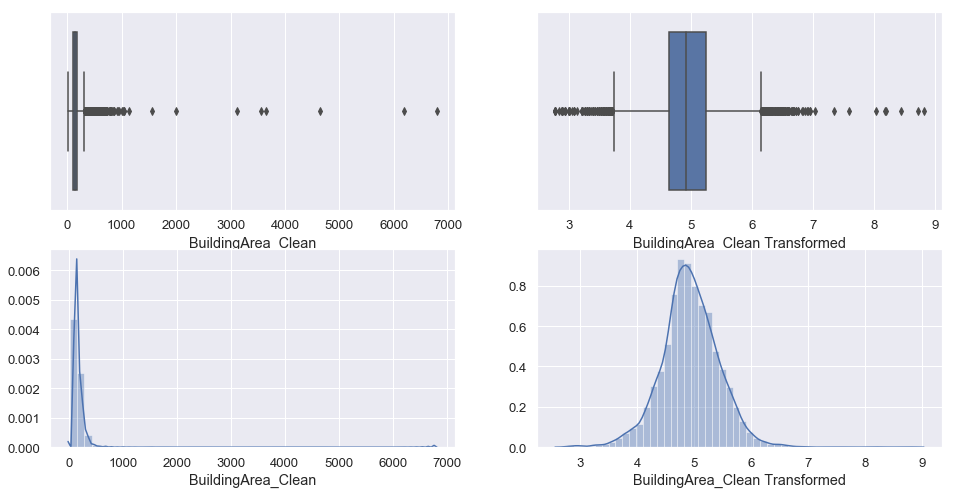

In [142]:
# log-transformed values look normally distributed
fig, axes = plt.subplots(2, 2)
column = 'BuildingArea_Clean'
column_lessthan = 50000
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0])
sns.boxplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1])
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

I'll look for the largest valid building size among properties in the suburbs with the largest land sizes.

In [143]:
biggest_landsizes = ['Park Orchards', 'Selby', 'Warrandyte', 'Mount Eliza', 'Frankston South',
                     'Langwarrin South', 'Langwarrin', 'Mooroolbark', 'Rye', 'Ferntree Gully',
                    'Boronia', 'Croydon', 'Mount Martha', 'Eltham', 'Werribee', 'Sunbury',
                     'Lilydale', 'Mornington', 'Reservoir', 'Balwyn North', 'Berwick', 'Upwey',
                    'Pakenham', 'Kilsyth', 'Greensborough']

In [144]:
df.loc[df['Suburb'].isin(biggest_landsizes), 'Suburb'].value_counts()

Reservoir          844
Balwyn North       420
Werribee           178
Sunbury            157
Greensborough      142
Croydon            133
Eltham              91
Ferntree Gully      70
Mooroolbark         62
Boronia             55
Frankston South     51
Berwick             47
Kilsyth             22
Pakenham            20
Langwarrin          18
Warrandyte          14
Lilydale             7
Upwey                2
Name: Suburb, dtype: int64

In [145]:
# examining the largest recorded building areas for the suburbs with the largest land sizes
df.loc[df['Suburb'].isin(biggest_landsizes),
       ['Landsize_Clean', 'BuildingArea_Clean', 'Address', 'Suburb', 'Postcode',
        'Price_Clean', 'SellerG', 'Date_Clean', 'Rooms', 'Bathroom', 'Car']].sort_values(by='BuildingArea_Clean', ascending=False).head()

,Landsize_Clean,BuildingArea_Clean,Address,Suburb,Postcode,Price_Clean,SellerG,Date_Clean,Rooms,Bathroom,Car
14387,3617.0,3647.0,169 Humphries Rd,Frankston South,3199,NaN,hockingstuart,2017-07-01,3,2.0,5.0
15628,836.0,789.0,50 Carlisle Rd,Ferntree Gully,3156,1100000.0,Schroeder,2017-06-17,5,3.0,2.0
1110,713.0,720.0,15 Illawarra Rd,Balwyn North,3104,1903000.0,Noel,2016-07-16,3,1.0,2.0
16680,970.0,665.0,64 The Boulevard,Balwyn North,3104,NaN,Marshall,2017-05-27,5,2.0,2.0
29652,657.0,660.0,30 Leonard Dr,Langwarrin,3910,570000.0,Barry,2018-01-06,4,2.0,2.0


* [Property 14387](https://www.domain.com.au/property-profile/169-humphries-road-frankston-south-vic-3199) Landsize is 3648 and the building doesn't encompass the entire property, so the building area of 3647 is unreasonable. [Second source](https://www.hockingstuart.com.au/property/169-humphries-road-frankston-south-vic-3199-3198779) for more pictures.
* [Property 15628](https://www.onthehouse.com.au/property/vic/ferntree-gully-3156/50-carlisle-rd-ferntree-gully-vic-3156-6491471) Building area matches.

Since 789 is the largest valid building area found, I will assume all building areas > 789 are incorrect.

In [146]:
df['BuildingArea_Clean'].describe()

count    13577.000000
mean       158.861342
std        133.256989
min         16.000000
25%        103.000000
50%        137.000000
75%        189.000000
max       6791.000000
Name: BuildingArea_Clean, dtype: float64

In [147]:
# will lose building areas for 23 properties
df.loc[df['BuildingArea_Clean'] > 789, :].shape

(23, 47)

In [148]:
df.loc[df['BuildingArea_Clean'] > 789, 'BuildingArea_Incorrect'] = 1
df.loc[df['BuildingArea_Clean'] > 789, 'BuildingArea_Clean'] = np.NaN

In [149]:
df['BuildingArea_Clean'].describe()

count    13554.000000
mean       155.785791
std         83.226258
min         16.000000
25%        103.000000
50%        136.745000
75%        188.000000
max        789.000000
Name: BuildingArea_Clean, dtype: float64

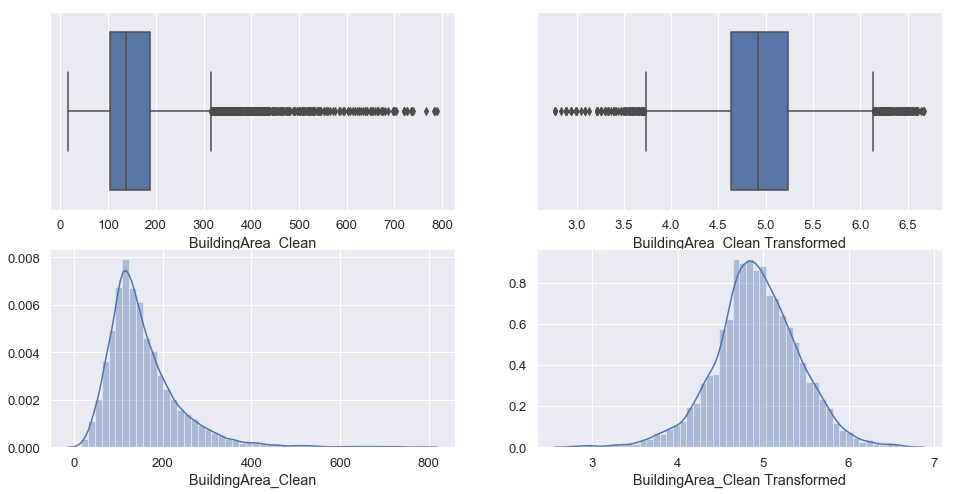

In [150]:
# log-transformed values seem normally distributed
fig, axes = plt.subplots(2, 2)
column = 'BuildingArea_Clean'
column_lessthan = 5000
sns.boxplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[0][0])
sns.distplot(df.loc[df[column] < column_lessthan, column].dropna(), ax=axes[1][0])
sns.boxplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[0][1])
axes[0][1].set_xlabel(column+' Transformed')
sns.distplot(np.log(df.loc[df[column] < column_lessthan, column].dropna()), ax=axes[1][1])
axes[1][1].set_xlabel(column+' Transformed')

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

The range for the cleaned BuildingArea values seems more reasonable than before.

In [151]:
# saving the current data to load in the next notebook
df.to_pickle('data/melbourne-housing-part2.pickle')

# Continued in next notebook